In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
from scipy.stats import linregress
import glob
import researchpy as rp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
from statsmodels.stats.anova import AnovaRM
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [58]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('uM')[0].split('_')[-1])

In [62]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary
EXPERIMENT_TIME = "1_MIN"
plate_type = 'DIV19'

PERTURBATION = "CNO"
firstTableHeading = "Number of Spikes"

FOLDER_PATH = f"{parent}/data/DIV19_CNO/Div19_1minute"
folder_dict = {}
doses= {"basal": "",
        "dose1": "",
        "dose2": "",
        "dose3": "",
        "dose4": ""
        }
## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath
inc_doses = []
## get doses names in increasing order 
# Extract dose names and sort them
dose_names = [name for name in folder_dict.keys() if 'basal' not in name]
dose_names.sort(key=custom_sort)

# Initialize doses dictionary
doses = {"basal": "basal"}

# Map the sorted doses to 'dose1', 'dose2', etc.
for i, dose_name in enumerate(dose_names, start=1):
    doses[f"dose{i}"] = dose_name.split("_")[-1]

# Output the updated doses dictionary
print("Doses:", doses)

# for dose in doses:
#     for folder_name in folder_dict:
#         if dose in folder_name:
#             doses[dose] = folder_dict[folder_name].split("/")[-1].split("_")[-1]
#         else:
#             inc_doses.append(folder_dict[folder_name].split("/")[-1])
# inc_doses = list(set(inc_doses))
# inc_doses.sort(key= custom_sort)
# for val in inc_doses: 
#     for dosenum in doses:
#         doses[dosenum] = val
# doses, inc_doses

Doses: {'basal': 'basal', 'dose1': '5uMCNO', 'dose2': '10uMCNO', 'dose3': '15uMCNO', 'dose4': '20uMCNO'}


In [38]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary
EXPERIMENT_TIME = "1_MIN"
plate_type = 'DIV19'

PERTURBATION = "CNO"
firstTableHeading = "Number of Spikes"
## conditions taken: ### we will define this as dose1,dose2, dose3, dose4, each incrementing in terms of doses
basal_folder = f"{parent}/data/DIV19_CNO/Div19_1minute/Div19_basal"
dose1_folder = f"{parent}/data/DIV19_CNO/Div19_1minute/Div19_5uMCNO"
dose2_folder = f"{parent}/data/DIV19_CNO/Div19_1minute/Div19_10uMCNO"
dose3_folder =f"{parent}/data/DIV19_CNO/Div19_1minute/Div19_15uMCNO"
dose4_folder = f"{parent}/data/DIV19_CNO/Div19_1minute/Div19_20uMCNO"

doses= {"basal": "basal",
        "dose1": "5uM_CNO",
        "dose2": "10uM_CNO",
        "dose3": "15uM_CNO",
        "dose4": '20uM_CNO'
        } 
# basal_df= pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 basal(000)(000)_CompiledData(1).csv",
#                     skiprows = lines_to_skip)

# bicucilin_df = pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 bicu 6 microM(000)(000)_CompiledData.csv",
#                          skiprows = lines_to_skip)

# basal_df = basal_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# bicucilin_df = bicucilin_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# basal_df
dose4_folder

'/home/poojaparameswaran/Documents/SoderlingLab/MEA_analysis/data/DIV19_CNO/Div19_1minute/Div19_20uMCNO'

In [22]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict
basal_files_dict = read_csvs_to_dict(basal_folder)
dose1_files_dict = read_csvs_to_dict(dose1_folder)
dose2_files_dict = read_csvs_to_dict(dose2_folder)
dose3_files_dict = read_csvs_to_dict(dose3_folder)
dose4_files_dict = read_csvs_to_dict(dose4_folder)
for ind, dictionary in enumerate([basal_files_dict, dose1_files_dict, dose2_files_dict, dose3_files_dict, dose4_files_dict]):
    print(list(doses.keys())[ind], dictionary.keys() )

basal dict_keys(['plate_1', 'plate_3'])
dose1 dict_keys(['plate_1', 'plate_3'])
dose2 dict_keys(['plate_1', 'plate_3'])
dose3 dict_keys(['plate_3', 'plate_1'])
dose4 dict_keys(['plate_3', 'plate_1'])


In [23]:
def concat_plates(dfs_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in dfs_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value for key, value in testparams_concat.items()}
    return testparams_concat

basal_dict_wmeanSEM= concat_plates(basal_files_dict, firstTableHeading)
dose1_dict_wmeanSEM = concat_plates(dose1_files_dict, firstTableHeading)
dose2_dict_wmeanSEM = concat_plates(dose2_files_dict, firstTableHeading)
dose3_dict_wmeanSEM = concat_plates(dose3_files_dict, firstTableHeading)
dose4_dict_wmeanSEM = concat_plates(dose4_files_dict, firstTableHeading)



In [24]:
def remove_mean_SEM(dictionary, chemical_type):
    for key, value in dictionary.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            dictionary[key] = value.drop(index=to_drop)
        dictionary[key]['Chemical_Type']=chemical_type
    return dictionary

basal_dictmessy = remove_mean_SEM(basal_dict_wmeanSEM, chemical_type="basal")
dose1_dictmessy = remove_mean_SEM(dose1_dict_wmeanSEM,chemical_type=doses['dose1'])
dose2_dictmessy = remove_mean_SEM(dose2_dict_wmeanSEM, chemical_type=doses['dose2'])
dose3_dictmessy = remove_mean_SEM(dose3_dict_wmeanSEM, chemical_type=doses['dose3'])
dose4_dictmessy = remove_mean_SEM(dose4_dict_wmeanSEM,chemical_type=doses['dose4'])

# print(basal_dict['Number of Covered Electrodes'].columns)
# dose1_dictmessy['Mean Firing Rate (Hz)']
dose1_dictmessy.keys()

dict_keys(['Number of Spikes', 'Mean Firing Rate (Hz)', 'ISI Coefficient of Variation - Avg', 'Number of Active Electrodes', 'Weighted Mean Firing Rate (Hz)', 'Number of Bursts', 'Number of Bursting Electrodes', 'Burst Duration - Avg (sec)', 'Burst Duration - Std (sec)', 'Number of Spikes per Burst - Avg', 'Number of Spikes per Burst - Std', 'Mean ISI within Burst - Avg (sec)', 'Mean ISI within Burst - Std (sec)', 'Median ISI within Burst - Avg (sec)', 'Median ISI within Burst - Std (sec)', 'Median/Mean ISI within Burst - Avg', 'Median/Mean ISI within Burst - Std', 'Inter-Burst Interval - Avg (sec)', 'Inter-Burst Interval - Std (sec)', 'Burst Frequency - Avg (Hz)', 'Burst Frequency - Std (Hz)', 'IBI Coefficient of Variation - Avg', 'IBI Coefficient of Variation - Std', 'Burst Percentage - Avg', 'Burst Percentage - Std', 'Number of Network Bursts', 'Network Burst Frequency', 'Network Burst Duration - Avg (sec)', 'Network Burst Duration - Std (sec)', 'Number of Spikes per Network Burst -

In [25]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    experiment_df.index = ["Replicate{}".format(i+1) for i in range(len(experiment_df))]
    return experiment_df

basal_dict = {key: rename_row_names(df) for key, df in basal_dictmessy.items()}
dose1_dict = {key: rename_row_names(df) for key, df in dose1_dictmessy.items()}
dose2_dict = {key: rename_row_names(df) for key, df in dose2_dictmessy.items()}
dose3_dict = {key: rename_row_names(df) for key, df in dose3_dictmessy.items()}
dose4_dict = {key: rename_row_names(df) for key, df in dose4_dictmessy.items()}

dose4_dict['Area Under Normalized Cross-Correlation']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,0.712106,0.916605,0.875747,0.215579,0.867783,0.869199,0.462477,0.852187,20uM_CNO
Replicate2,0.871235,0.938263,0.804486,0.785828,0.748183,0.619096,0.874742,0.647547,20uM_CNO
Replicate3,0.790705,0.795656,0.846989,0.819675,0.857378,0.610070,0.802793,0.809473,20uM_CNO
Replicate4,0.818763,0.777935,0.749519,0.785684,0.724981,0.429507,0.944106,0.705719,20uM_CNO
Replicate5,0.743455,0.779894,0.687082,0.924830,0.765814,0.646261,0.896991,0.667357,20uM_CNO
Replicate6,0.829449,0.376899,0.766757,0.851397,0.825210,0.860674,0.870856,0.865879,20uM_CNO
Replicate7,0.821152,0.760410,0.854468,0.804043,0.572257,0.682374,0.762057,0.812944,20uM_CNO
Replicate8,0.884737,0.839606,0.839958,0.833425,0.842107,0.774833,0.901823,0.869006,20uM_CNO
Replicate9,0.841521,0.758798,0.946694,0.852091,0.905071,0.888100,0.786825,0.888134,20uM_CNO
Replicate10,0.800384,0.840890,0.891789,0.895376,0.781688,0.862235,0.870575,0.882702,20uM_CNO


In [27]:
all_dicts = dict(zip(doses.keys(),[basal_dict, dose1_dict, dose2_dict, dose3_dict, dose4_dict]))
all_dicts['dose1']

{'Number of Spikes':                 GPR37L 1     GPR37L 2     LGI2 A12      SLITRK5      THSD7 1  \
 Replicate1   3814.000000   915.000000  4853.000000  1634.000000  2229.000000   
 Replicate2   3359.000000   562.000000  5386.000000  3747.000000  3326.000000   
 Replicate3   1691.000000  2968.000000  2112.000000  2576.000000  2736.000000   
 Replicate4    196.000000   589.000000  1244.000000  2880.000000  3488.000000   
 Replicate5      0.000000  2322.000000  1848.000000  3369.000000     0.000000   
 Replicate6    176.000000  1631.000000   739.000000  2943.000000   471.000000   
 Replicate7    967.000000  1112.000000   713.000000  1118.000000  2215.000000   
 Replicate8      0.000000  4532.000000  2565.000000    62.000000  1559.000000   
 Replicate9    246.000000  2876.000000   664.000000   614.000000  2410.000000   
 Replicate10  1760.000000  4045.000000   736.000000  2294.000000    38.000000   
 Replicate11   918.000000    12.000000  1615.000000  1466.000000  1586.000000   
 Replica

In [28]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

TestParams_dict = combine_chem_types(all_dicts)
print(TestParams_dict['Network Burst Duration - Avg (sec)']['Chemical_Type'].unique())
TestParams_dict['Network Burst Duration - Avg (sec)']

['basal' '5uM_CNO' '10uM_CNO' '15uM_CNO' '20uM_CNO']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.341920,0.365813,0.244352,0.167614,0.325920,0.287291,0.594080,0.272806,basal
Replicate2,0.227520,0.253360,NaN,0.494000,0.228423,NaN,0.316949,0.459620,basal
Replicate3,0.202187,0.404549,NaN,0.359486,NaN,NaN,0.539200,NaN,basal
Replicate4,0.426267,0.513627,0.386030,0.168811,0.230080,0.140960,0.289505,0.852827,basal
Replicate5,0.273200,0.422027,0.275640,0.453680,NaN,NaN,0.203297,0.224149,basal
...,...,...,...,...,...,...,...,...,...
Replicate20,0.631269,0.309073,0.848000,NaN,0.200880,0.326537,0.375853,1.183120,20uM_CNO
Replicate21,0.506208,0.288600,0.949080,0.255456,0.351920,0.326618,0.266527,0.420820,20uM_CNO
Replicate22,0.361080,0.336832,0.500160,0.208364,0.600544,0.392764,0.323050,0.342969,20uM_CNO
Replicate23,0.759547,0.268971,0.324808,0.250907,0.559180,0.243537,0.293053,0.403320,20uM_CNO


In [29]:
def impute_nans(testparam, table):
    chem_types = table['Chemical_Type']
    table = table.drop(columns=['Chemical_Type'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)

    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['Chemical_Type'] = chem_types
    return imputed_df

TestParams_dict_imputed = {test_param: table for test_param, table in TestParams_dict.items()}
for key, table in TestParams_dict.items():
    if table.loc[:, table.columns != 'Chemical_Type'].isna().all().all():
        del TestParams_dict_imputed[key]
    else:
        TestParams_dict_imputed[key] = impute_nans(key, table)

In [30]:
def melt_df_Long(df):
    new_df = pd.melt(df, id_vars=['Chemical_Type'], var_name='Gene', value_name='Value')
    return new_df

for test_param, table in TestParams_dict_imputed.items():
    TestParams_dict_imputed[test_param] = melt_df_Long(table)

In [32]:
## REMOVE UNT1
for testparam, table in TestParams_dict_imputed.items():
    TestParams_dict_imputed[testparam] = table[table['Gene'] != 'unt1']

In [33]:
def add_barlabels(ax, bar_width=0.35):
        # Iterate through the patches (bars) in the Axes object
        for bar in ax.patches:
                # The bar's width and location can be accessed through the bar's attributes
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                # Format the label with the desired precision here; round(y, 2) for two decimal places
                label = round(y, 1)
                
                
                # Place the label above the bar, centered
                ax.text(x, y, label, ha='center', va='bottom', color='pink', fontstyle='italic', fontsize=6,
                        bbox=dict(facecolor='pink', alpha=0.3, edgecolor='none', pad=0))

In [34]:
def add_slope_labels(ax, testparam_df, gene_slope_dict, bar_width=0.35):
    mutants = list(testparam_df['Gene'].unique())
    chemical_types = list(testparam_df['Chemical_Type'].unique())
    
    fig_width, fig_height = ax.figure.get_size_inches()
    numgenes_plot = range(len(mutants))
    eg_width = fig_width/ len(numgenes_plot)
    bar_width = ax.patches[0].get_width()
    space_genes = numgenes_plot + eg_width -1 - bar_width
    print(space_genes)
    
    bars = ax.patches
    y_values = [bar.get_height() for bar in bars]
    top_yval = max(y_values)
    for ind, gene in enumerate(mutants):
        ax.text(space_genes[ind], top_yval +(0.01 * top_yval),
                    f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
                    f"P-value = {gene_slope_dict[gene]['p']:.2e}",
                    color='green', fontweight='bold', fontsize=6,
                    ha='center', va='bottom',
                    bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))


In [35]:
import itertools

def compute_slope(testparam_df):
    genes = list(testparam_df['Gene'].unique())
    print(genes)
    gene_data_dict = {gene: [] for gene in genes}
    gene_slope_dict = {gene: float for gene in genes}
    for gene, perturb in itertools.product(testparam_df['Gene'].unique(), testparam_df['Chemical_Type'].unique()):
        mask = testparam_df['Gene'].str.contains(gene) & testparam_df['Chemical_Type'].str.contains(perturb)
        gene_data_dict[gene] = testparam_df[mask]['Value'].tolist()
        slope, intercept, r, p, se = linregress(np.arange(len(gene_data_dict[gene])), gene_data_dict[gene])
        gene_slope_dict[gene] = {"slope":slope, "r":r, "p":p, "se":se}
    return gene_slope_dict

trial = compute_slope(TestParams_dict_imputed['Network Burst Duration - Avg (sec)'])

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']


In [36]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -8.821739130434779, 'r': -0.057581567091581395, 'p': 0.7892740649267305, 'se': 32.609054969473995}, 'GPR37L_2': {'slope': 3.1856521739130432, 'r': 0.01781987414340764, 'p': 0.9341337378763379, 'se': 38.10775962201819}, 'LGI2_A12': {'slope': -40.82173913043478, 'r': -0.26934849714796133, 'p': 0.20309963310330245, 'se': 31.11796467563743}, 'SLITRK5': {'slope': -33.29869565217391, 'r': -0.25515617099071597, 'p': 0.22885320998749978, 'se': 26.902416999899863}, 'THSD7_1': {'slope': -1.327391304347828, 'r': -0.009674566102468595, 'p': 0.9642139350237143, 'se': 29.25066918967436}, 'THSD7_2': {'slope': 14.147391304347826, 'r': 0.09006988679167742, 'p': 0.6755468904458712, 'se': 33.351594258919874}, 'unt2': {'slope': -31.71086956521739, 'r': -0.20214983886391497, 'p': 0.3434908954232375, 'se': 32.75392733442216}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143

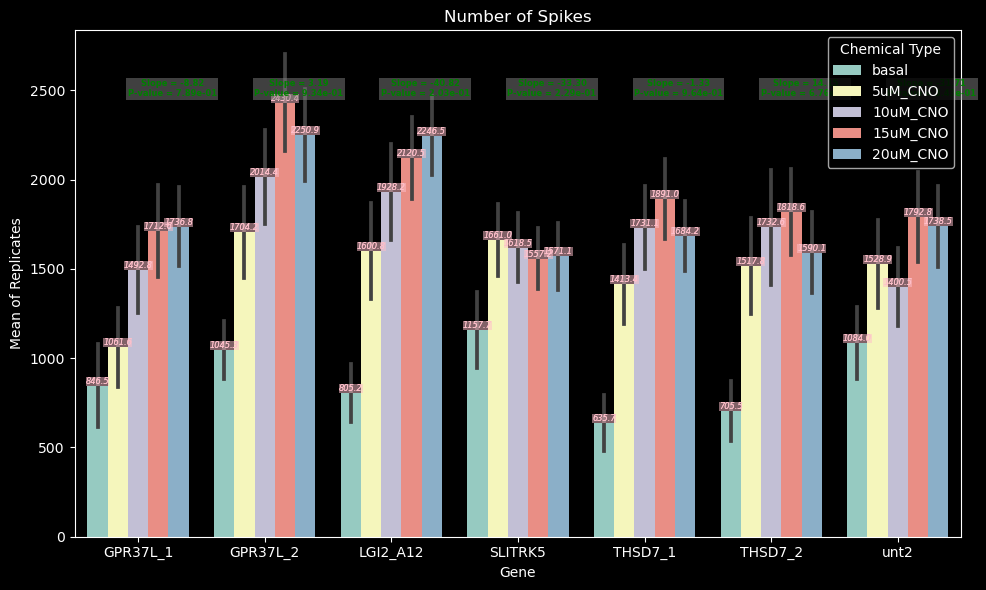

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.01837861782608696, 'r': -0.057581549229477315, 'p': 0.7892741288600125, 'se': 0.06793553250896325}, 'GPR37L_2': {'slope': 0.006636779999999987, 'r': 0.017819886456343442, 'p': 0.9341336924612421, 'se': 0.07939116648252482}, 'LGI2_A12': {'slope': -0.08504528826086954, 'r': -0.26934849634812985, 'p': 0.20309963449686974, 'se': 0.06482909206657032}, 'SLITRK5': {'slope': -0.06937227608695652, 'r': -0.25515614242251394, 'p': 0.22885326390512695, 'se': 0.056046703526318076}, 'THSD7_1': {'slope': -0.002765410434782606, 'r': -0.00967460772388974, 'p': 0.9642137811627929, 'se': 0.060938893831994675}, 'THSD7_2': {'slope': 0.029473733478260863, 'r': 0.09006989119800228, 'p': 0.6755468754172809, 'se': 0.06948248837068381}, 'unt2': {'slope': -0.06606430391304348, 'r': -0.20214982090533284, 'p': 0.34349093920461216, 'se': 0.06823734699991137}}
[0.26857143 1.26857143 2.26857143 3.2

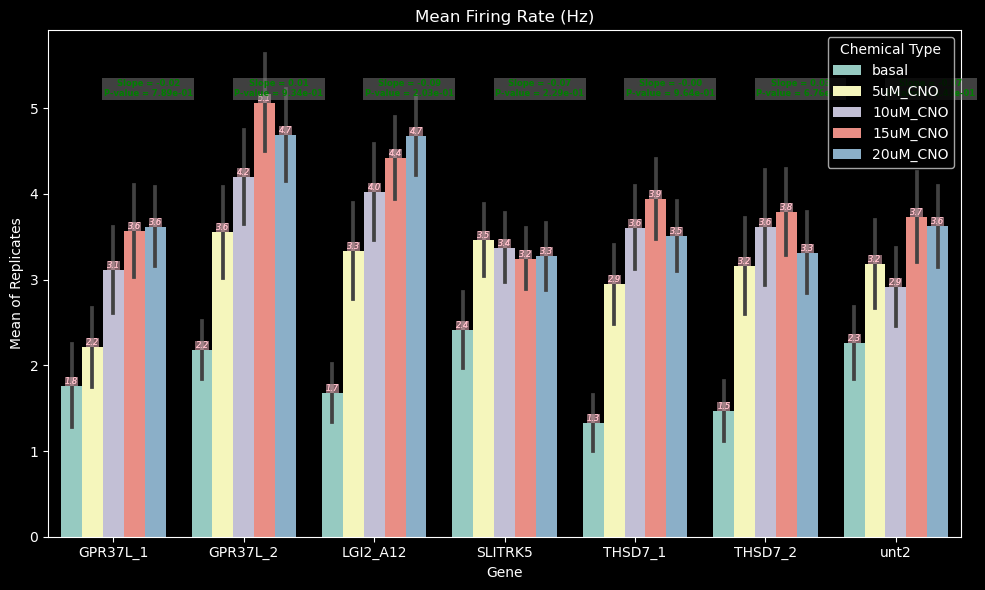

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.01116829079453766, 'r': -0.04183587974482418, 'p': 0.8461003298346587, 'se': 0.05686513493782016}, 'GPR37L_2': {'slope': -0.07316519988527043, 'r': -0.24001536978284965, 'p': 0.2586148194420799, 'se': 0.06309139184369891}, 'LGI2_A12': {'slope': -0.04180256652173912, 'r': -0.13254453404049638, 'p': 0.5369689940990663, 'se': 0.06664706391882734}, 'SLITRK5': {'slope': -0.018310745217391296, 'r': -0.06841965433531842, 'p': 0.7507387266867307, 'se': 0.05692393269843343}, 'THSD7_1': {'slope': -0.07542149913043479, 'r': -0.3344835779980828, 'p': 0.11014095109777941, 'se': 0.04530488422605163}, 'THSD7_2': {'slope': -0.15567352913043478, 'r': -0.43054662905590485, 'p': 0.035709864396631395, 'se': 0.06957662055205571}, 'unt2': {'slope': -0.11761277913043475, 'r': -0.35918749762602786, 'p': 0.08474751488852228, 'se': 0.06515190728022537}}
[0.26857143 1.26857143 2.26857143 3.268

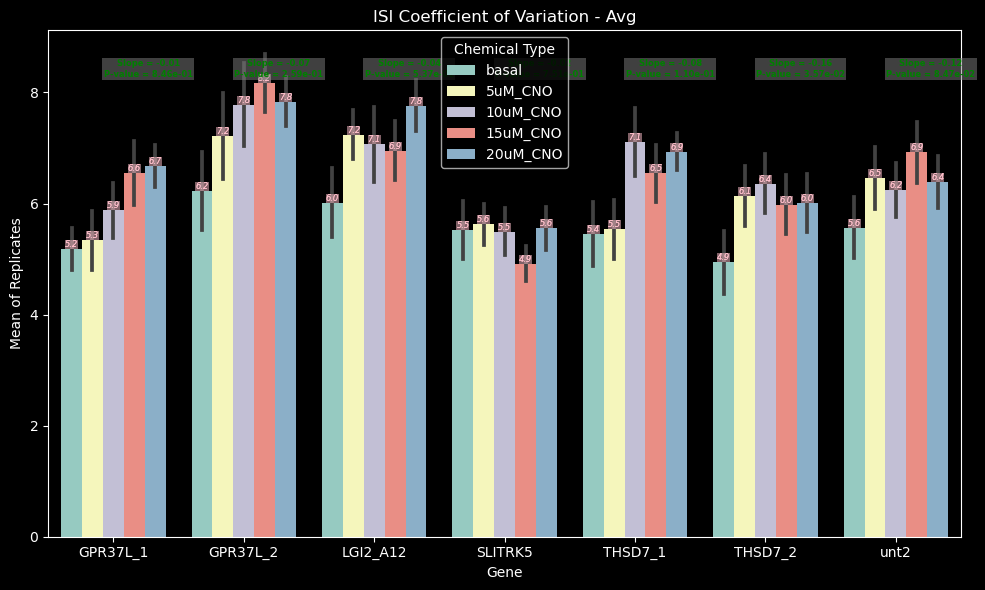

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.08, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.046188021535170064}, 'GPR37L_2': {'slope': -0.014347826086956525, 'r': -0.056577202049891494, 'p': 0.792871032458735, 'se': 0.053980524303373856}, 'LGI2_A12': {'slope': -0.01, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.005773502691896258}, 'SLITRK5': {'slope': -0.029130434782608697, 'r': -0.13448276307346765, 'p': 0.5309778895853319, 'se': 0.045762086145454836}, 'THSD7_1': {'slope': -0.01565217391304348, 'r': -0.392015164665939, 'p': 0.0581469948783241, 'se': 0.007831208981163896}, 'THSD7_2': {'slope': 0.01652173913043478, 'r': 0.4137937849251577, 'p': 0.04442311606898516, 'se': 0.007749589533577613}, 'unt2': {'slope': -0.01, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.005773502691896258}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


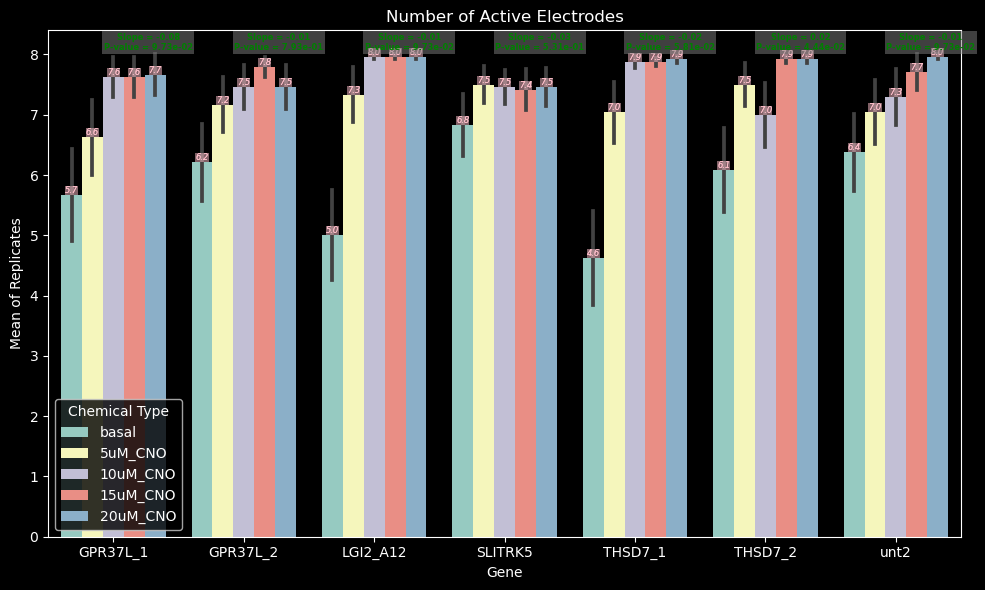

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.006602173920538959, 'r': -0.02135095598997442, 'p': 0.9211184130769807, 'se': 0.06591120976190713}, 'GPR37L_2': {'slope': 0.00965508577241803, 'r': 0.028545868752810295, 'p': 0.8946626107288791, 'se': 0.0720816157430249}, 'LGI2_A12': {'slope': -0.08333397826086955, 'r': -0.2652650864901514, 'p': 0.21029880883833713, 'se': 0.06457832590924255}, 'SLITRK5': {'slope': -0.0614870247826087, 'r': -0.235516176871089, 'p': 0.26791780425388223, 'se': 0.0540953286712047}, 'THSD7_1': {'slope': 0.0035582091304347707, 'r': 0.01212415499077493, 'p': 0.955160924748993, 'se': 0.06256576049129758}, 'THSD7_2': {'slope': 0.024701219130434788, 'r': 0.07574940069526068, 'p': 0.7249954622269986, 'se': 0.06932314762087151}, 'unt2': {'slope': -0.06550180391304349, 'r': -0.20071851316734937, 'p': 0.3469908566430766, 'se': 0.06815927609590883}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26

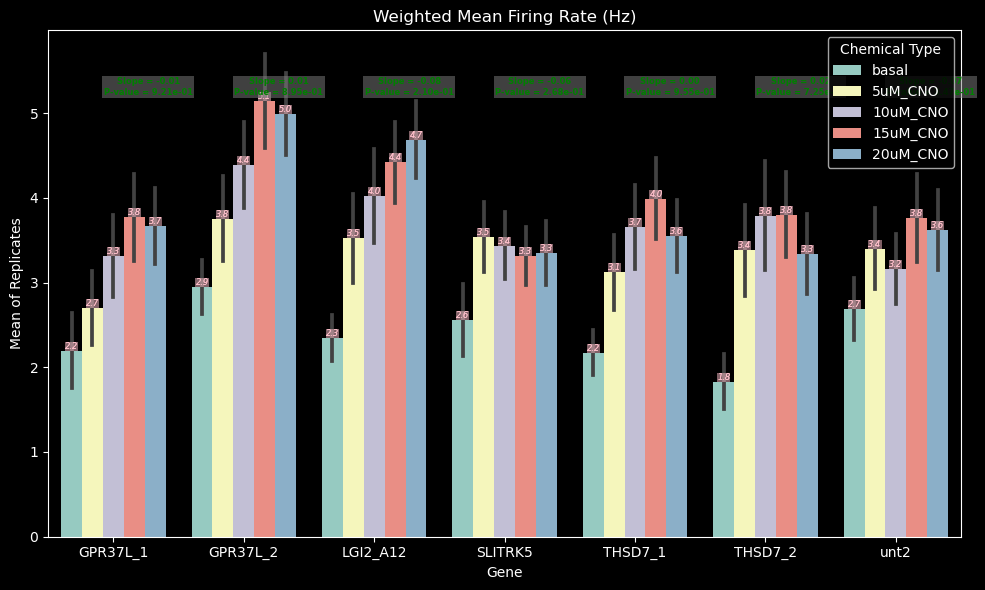

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.9004347826086956, 'r': -0.12333972536818211, 'p': 0.5658446664024966, 'se': 1.5445755920392503}, 'GPR37L_2': {'slope': -0.4613043478260869, 'r': -0.05307825787183501, 'p': 0.8054335257287412, 'se': 1.8503203053214983}, 'LGI2_A12': {'slope': -1.623478260869565, 'r': -0.2098711725012877, 'p': 0.32497417090809, 'se': 1.6125042441993336}, 'SLITRK5': {'slope': -1.4978260869565216, 'r': -0.24287679423098973, 'p': 0.25280792734344265, 'se': 1.2754438566880433}, 'THSD7_1': {'slope': 0.39043478260869563, 'r': 0.06240849627413932, 'p': 0.7720466253838478, 'se': 1.3312083743005774}, 'THSD7_2': {'slope': 0.9052173913043479, 'r': 0.1247058991484939, 'p': 0.5615155167049186, 'se': 1.5355043035534977}, 'unt2': {'slope': -1.1400000000000001, 'r': -0.21961483305874693, 'p': 0.3024889265063405, 'se': 1.0796865548174115}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.268571

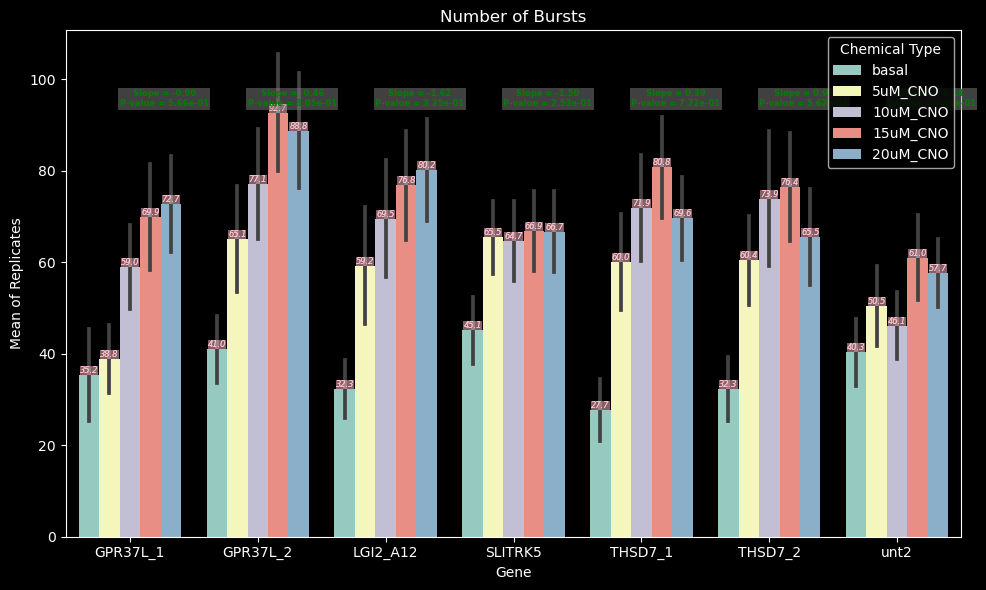

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.08, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.046188021535170064}, 'GPR37L_2': {'slope': -0.014347826086956525, 'r': -0.056577202049891494, 'p': 0.792871032458735, 'se': 0.053980524303373856}, 'LGI2_A12': {'slope': -0.01, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.005773502691896258}, 'SLITRK5': {'slope': 0.0008695652173913062, 'r': 0.0033532637550742262, 'p': 0.9875929260832564, 'se': 0.055286699316105}, 'THSD7_1': {'slope': -0.009130434782608696, 'r': -0.19110661718118183, 'p': 0.3710369345700124, 'se': 0.009998281343976309}, 'THSD7_2': {'slope': 0.02826086956521739, 'r': 0.3036974260913602, 'p': 0.14910014179190145, 'se': 0.01890255338845285}, 'unt2': {'slope': -0.01, 'r': -0.3464101615137754, 'p': 0.09726417772963672, 'se': 0.005773502691896258}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


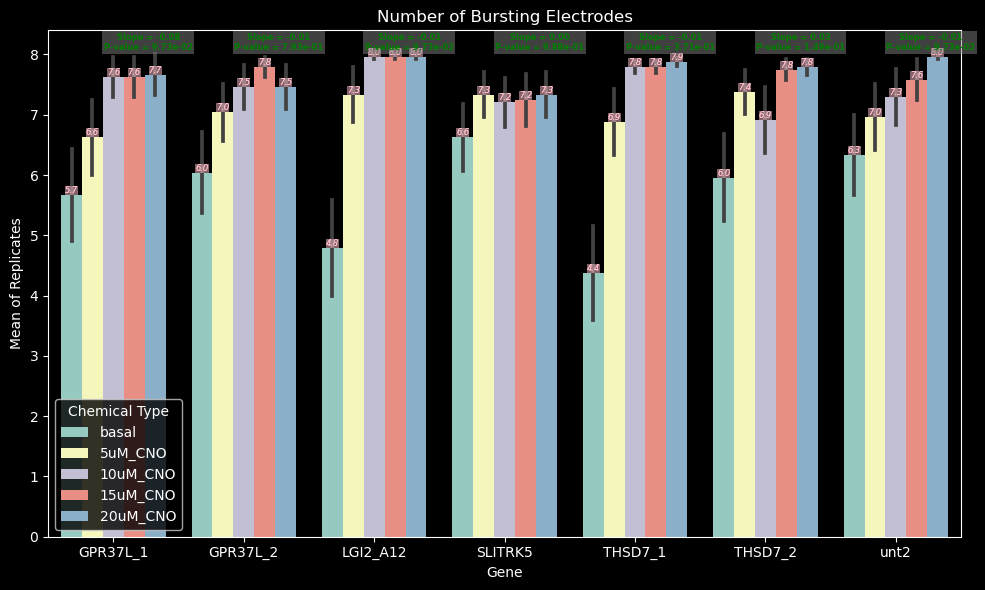

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0017761869814803676, 'r': 0.25153195549942936, 'p': 0.2357610368573166, 'se': 0.0014571081187444736}, 'GPR37L_2': {'slope': 0.0008407951766827431, 'r': 0.1142027611476662, 'p': 0.5951736262128113, 'se': 0.0015593785043642617}, 'LGI2_A12': {'slope': 0.0012526134782608698, 'r': 0.11756164185137503, 'p': 0.5843170164132347, 'se': 0.002255890574902683}, 'SLITRK5': {'slope': 0.0023835239130434783, 'r': 0.24418700261600437, 'p': 0.2501774540761765, 'se': 0.002018067261992258}, 'THSD7_1': {'slope': 7.382173913043501e-05, 'r': 0.008303272475158439, 'p': 0.9692838045596806, 'se': 0.0018954340172234478}, 'THSD7_2': {'slope': -0.0013062913043478254, 'r': -0.10839544116473725, 'p': 0.6141428668373836, 'se': 0.002554178140925738}, 'unt2': {'slope': -0.0016507560869565212, 'r': -0.12752429002167914, 'p': 0.5526319521619277, 'se': 0.002737274038246108}}
[0.26857143 1.26857143 2.2685

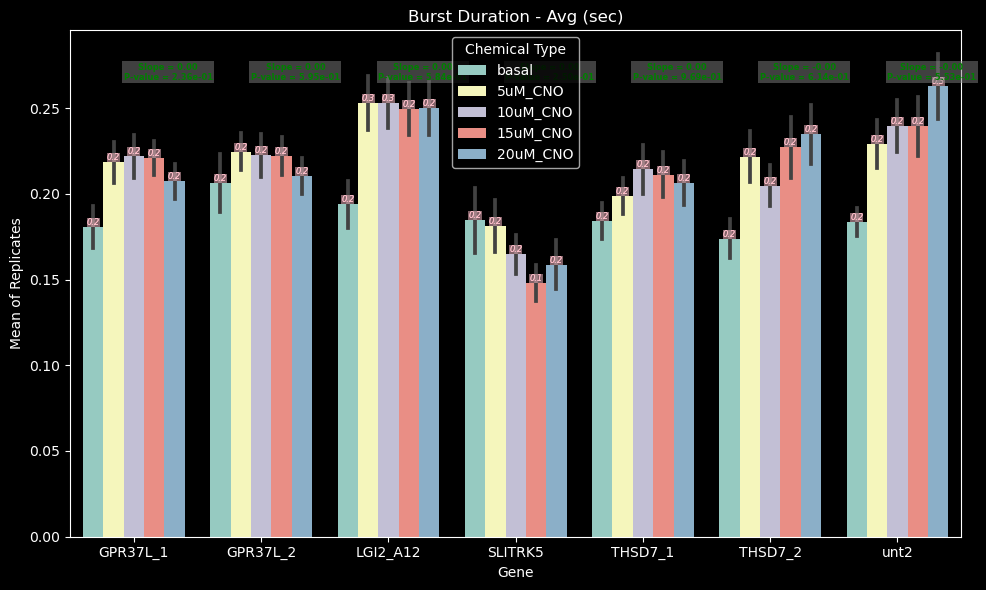

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.00352049281476744, 'r': 0.5138896092680602, 'p': 0.010207100226687913, 'se': 0.0012529589470936069}, 'GPR37L_2': {'slope': 0.0004266807107659754, 'r': 0.0774250588177468, 'p': 0.7191495345533956, 'se': 0.001171398028321593}, 'LGI2_A12': {'slope': 0.0032094117391304354, 'r': 0.3684964815842198, 'p': 0.07642079591229223, 'se': 0.0017261974897091745}, 'SLITRK5': {'slope': -9.227942914276947e-05, 'r': -0.02033436905286902, 'p': 0.9248636132001513, 'se': 0.0009673264240825615}, 'THSD7_1': {'slope': 0.00023665086956521723, 'r': 0.02855176788115863, 'p': 0.894640960390799, 'se': 0.0017663902894589744}, 'THSD7_2': {'slope': -0.0014564573913043478, 'r': -0.16595674975390895, 'p': 0.43833120657667535, 'se': 0.0018451302514435974}, 'unt2': {'slope': -0.0012745713043478262, 'r': -0.09820043544093313, 'p': 0.6480260743716549, 'se': 0.0027538177762317247}}
[0.26857143 1.26857143 2.

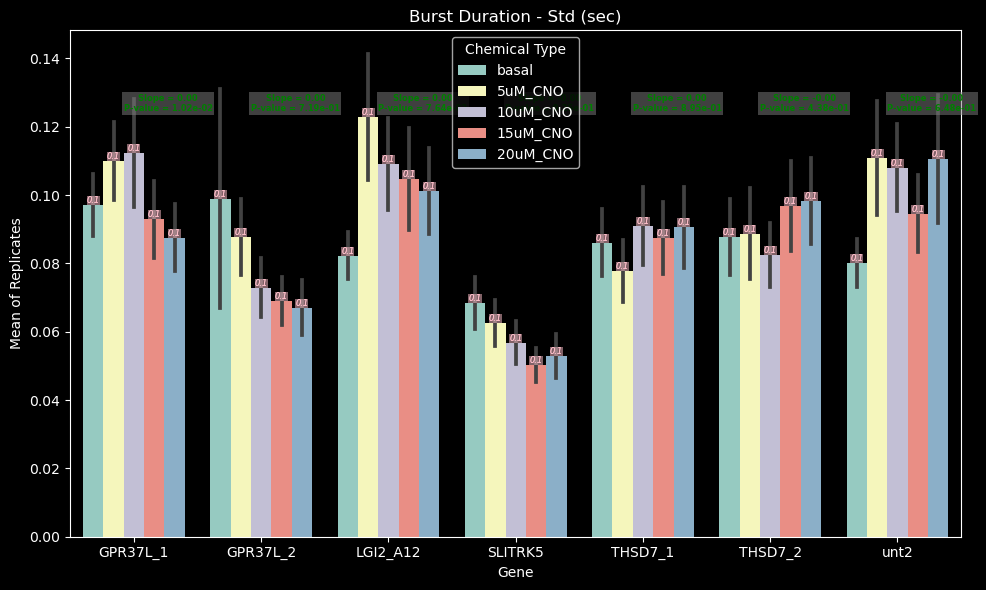

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.42333536145845446, 'r': 0.4921786149177274, 'p': 0.01456236325427582, 'se': 0.1596306806223312}, 'GPR37L_2': {'slope': 0.3284003524518267, 'r': 0.30809076974262983, 'p': 0.14301379513423365, 'se': 0.21620069693732252}, 'LGI2_A12': {'slope': 0.3137716004347826, 'r': 0.30829866144670837, 'p': 0.14273025289635888, 'se': 0.2064160247374827}, 'SLITRK5': {'slope': 0.21771330130434774, 'r': 0.20144885498132892, 'p': 0.3452023538179052, 'se': 0.22569026784002877}, 'THSD7_1': {'slope': 0.015307089130434857, 'r': 0.017063563094651714, 'p': 0.9369236902389282, 'se': 0.19122660425696772}, 'THSD7_2': {'slope': 0.1475870113043479, 'r': 0.1181957230920397, 'p': 0.5822771926552683, 'se': 0.2643504473915591}, 'unt2': {'slope': 0.1135866056521739, 'r': 0.0897908460794864, 'p': 0.6764988516293464, 'se': 0.26861229940711173}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.2685

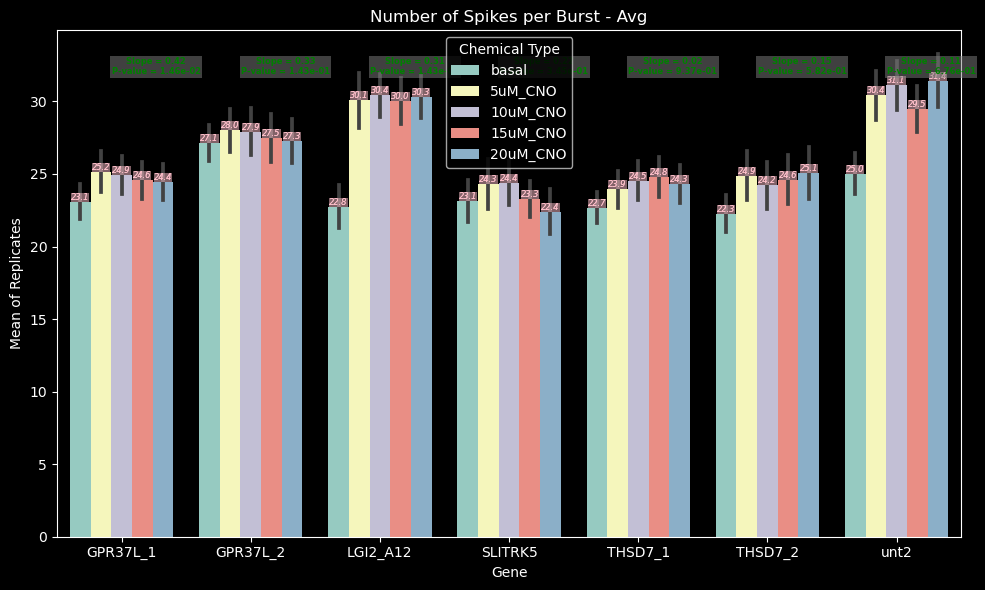

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.4380471270100413, 'r': 0.49421442926503595, 'p': 0.01409834918237598, 'se': 0.16427964493712346}, 'GPR37L_2': {'slope': 0.10919647881267966, 'r': 0.2093107916045299, 'p': 0.3262973100067752, 'se': 0.10876208975268009}, 'LGI2_A12': {'slope': 0.5371560578260869, 'r': 0.5421246146846899, 'p': 0.006207734754915383, 'se': 0.17751023305398303}, 'SLITRK5': {'slope': 0.0016174051925603055, 'r': 0.002272875553054919, 'p': 0.9915901914040212, 'se': 0.1517157657540585}, 'THSD7_1': {'slope': 0.01697167173913043, 'r': 0.01898799650883683, 'p': 0.9298261459407318, 'se': 0.19052669515525966}, 'THSD7_2': {'slope': -0.07134891478260869, 'r': -0.06560879828405261, 'p': 0.7606814696685053, 'se': 0.23135410906448214}, 'unt2': {'slope': 0.2682815069565217, 'r': 0.20585376386084098, 'p': 0.33453165479320157, 'se': 0.27190559691483496}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.2685714

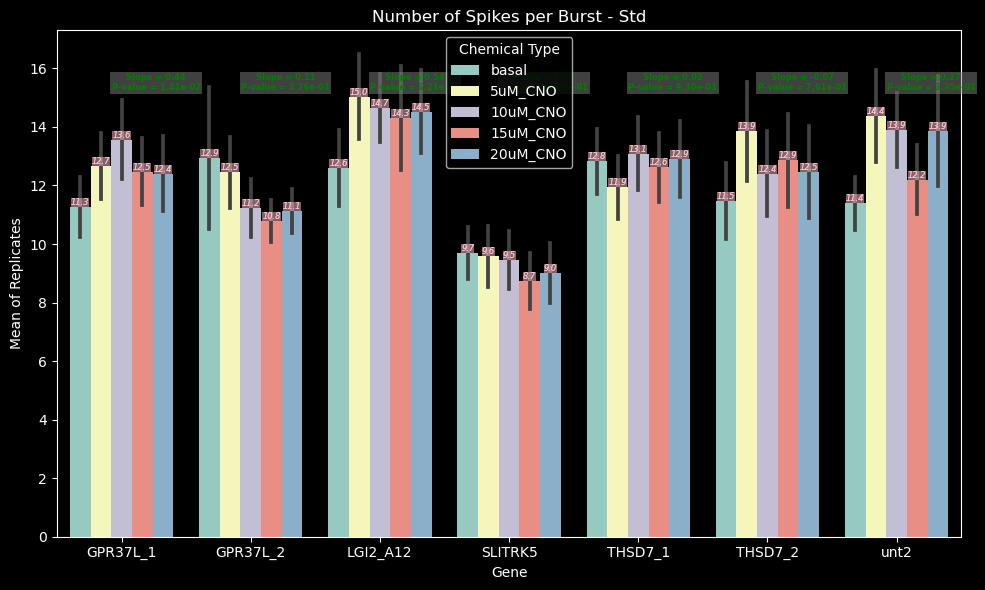

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -4.708341794633525e-05, 'r': -0.1614486880260924, 'p': 0.4510437167571456, 'se': 6.136022690089699e-05}, 'GPR37L_2': {'slope': -6.644079957090503e-05, 'r': -0.16589229787258372, 'p': 0.43851159614695934, 'se': 8.420493973289154e-05}, 'LGI2_A12': {'slope': 1.8572173913043486e-05, 'r': 0.049966656022709166, 'p': 0.8166447917195367, 'se': 7.91458766012909e-05}, 'SLITRK5': {'slope': 0.00019512739130434786, 'r': 0.15349347755655038, 'p': 0.4739421898839482, 'se': 0.00026781796043698927}, 'THSD7_1': {'slope': -1.2873478260869549e-05, 'r': -0.043017628336916414, 'p': 0.8418057758799131, 'se': 6.374349822415803e-05}, 'THSD7_2': {'slope': -0.00021472608695652175, 'r': -0.37816943280073884, 'p': 0.0684412303828601, 'se': 0.00011206613325777239}, 'unt2': {'slope': -6.91108695652174e-05, 'r': -0.19690454236098978, 'p': 0.3564195150014653, 'se': 7.336562546295351e-05}}
[0.26857143 1

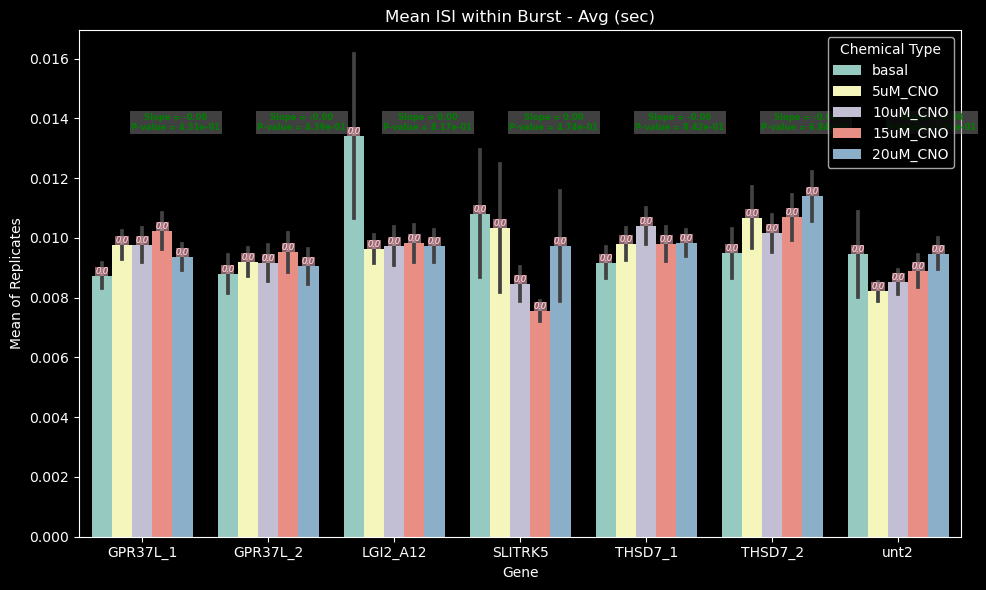

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -2.032101979992999e-05, 'r': -0.1332517615325911, 'p': 0.5347792833546186, 'se': 3.222336457311808e-05}, 'GPR37L_2': {'slope': -6.271851552245837e-05, 'r': -0.1717209526645352, 'p': 0.42235954545585364, 'se': 7.671169459703534e-05}, 'LGI2_A12': {'slope': 0.00011038304347826084, 'r': 0.3432692924311708, 'p': 0.10054101148912871, 'se': 6.439190507998111e-05}, 'SLITRK5': {'slope': -6.394697150258453e-05, 'r': -0.3064132577561913, 'p': 0.14531645857297923, 'se': 4.235374034273928e-05}, 'THSD7_1': {'slope': 3.014608695652174e-05, 'r': 0.12579437750001865, 'p': 0.5580770328255088, 'se': 5.068678112609398e-05}, 'THSD7_2': {'slope': -0.00019215521739130437, 'r': -0.32651244017287795, 'p': 0.11941843972478336, 'se': 0.00011859368409487423}, 'unt2': {'slope': 1.497391304347813e-06, 'r': 0.006131873535390388, 'p': 0.977314064518139, 'se': 5.2062211503362395e-05}}
[0.26857143 1.268

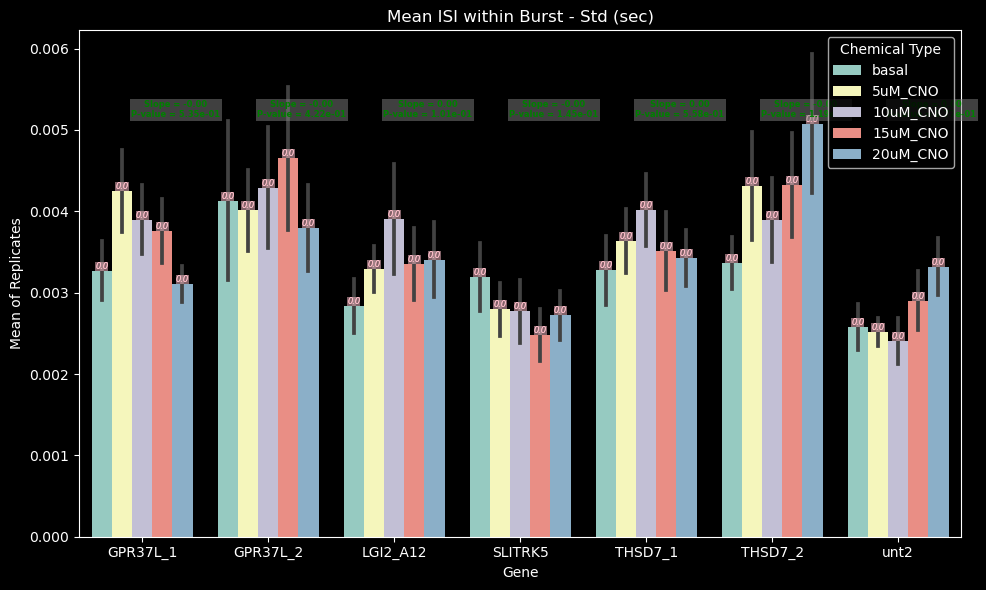

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 3.325754502737191e-06, 'r': 0.027325559400333488, 'p': 0.8991428041637153, 'se': 2.5938662863358686e-05}, 'GPR37L_2': {'slope': -8.966065041014207e-06, 'r': -0.04150243869655272, 'p': 0.8473128519406112, 'se': 4.601957245464823e-05}, 'LGI2_A12': {'slope': 3.7899565217391314e-05, 'r': 0.1677941437010134, 'p': 0.4332053793970655, 'se': 4.747277495555603e-05}, 'SLITRK5': {'slope': 0.0002693452173913044, 'r': 0.1922901972876288, 'p': 0.36802522312515984, 'se': 0.00029306195774672135}, 'THSD7_1': {'slope': -3.6670869565217385e-05, 'r': -0.2189387874473952, 'p': 0.30401715343297775, 'se': 3.484340937928551e-05}, 'THSD7_2': {'slope': -0.00013928782608695655, 'r': -0.32692155722289873, 'p': 0.11892885819656474, 'se': 8.584474727609825e-05}, 'unt2': {'slope': -6.490173913043478e-05, 'r': -0.3990932500357177, 'p': 0.05336923094605162, 'se': 3.179050914244334e-05}}
[0.26857143 1.2

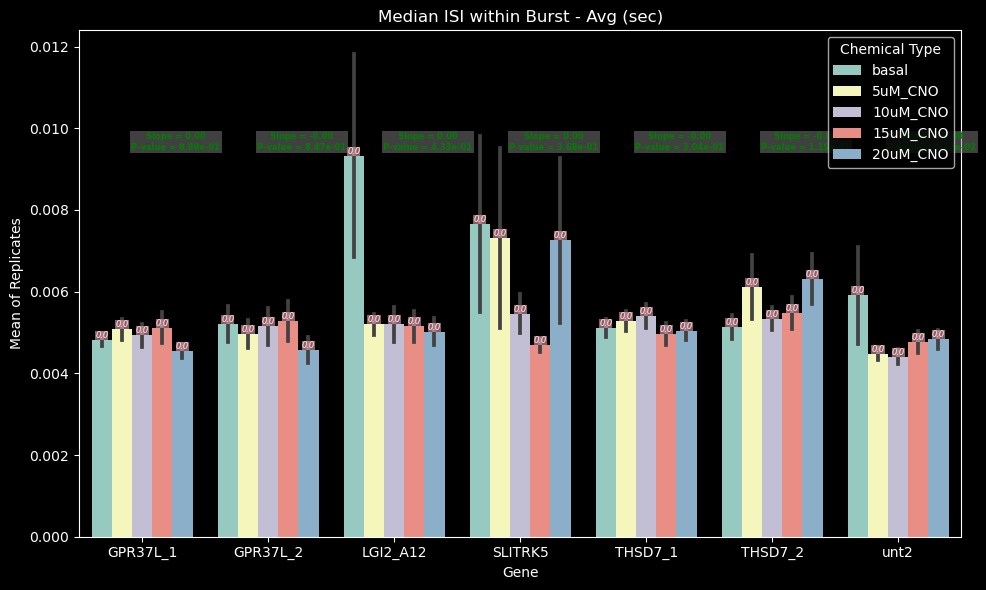

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -3.919939253813405e-06, 'r': -0.03811432851321686, 'p': 0.8596519569434896, 'se': 2.191109309283317e-05}, 'GPR37L_2': {'slope': -4.6947612147735675e-05, 'r': -0.13306805882138825, 'p': 0.5353476589051418, 'se': 7.45502058206166e-05}, 'LGI2_A12': {'slope': 7.226913043478261e-05, 'r': 0.2369854981215958, 'p': 0.2648564879551313, 'se': 6.316382447126291e-05}, 'SLITRK5': {'slope': -4.3283604139999446e-05, 'r': -0.21237199571581541, 'p': 0.31910902632777616, 'se': 4.246130625791867e-05}, 'THSD7_1': {'slope': -2.635478260869565e-05, 'r': -0.12550186347656042, 'p': 0.5590001431034874, 'se': 4.4417128315856176e-05}, 'THSD7_2': {'slope': -0.0002416078260869565, 'r': -0.31105853638415454, 'p': 0.1390040131758129, 'se': 0.00015738369455183882}, 'unt2': {'slope': -9.858260869565218e-05, 'r': -0.41085908886729305, 'p': 0.046107742380693824, 'se': 4.663881188592524e-05}}
[0.26857143 

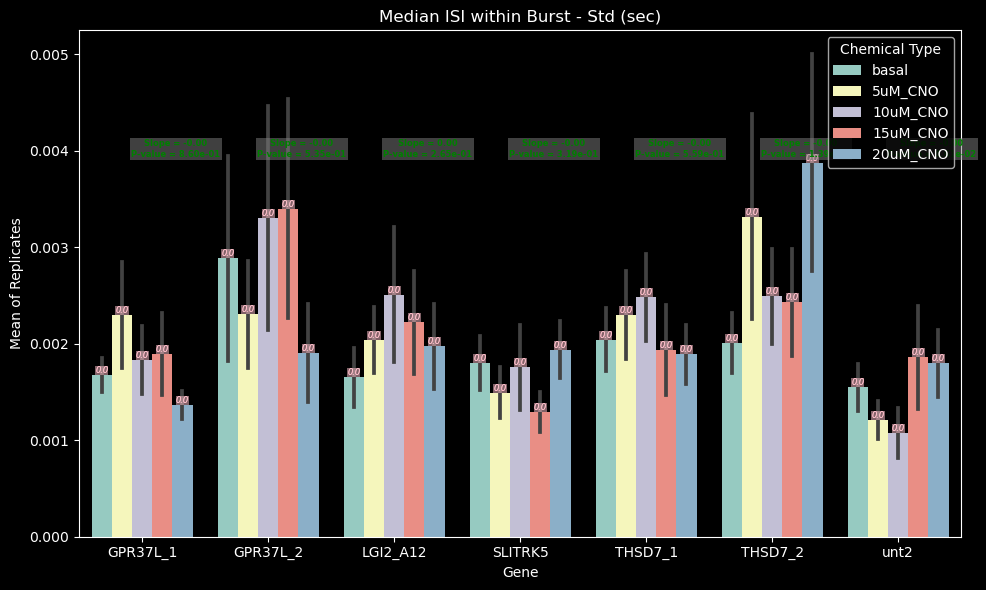

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.001134213195210755, 'r': -0.1052956103670618, 'p': 0.6243684728320815, 'se': 0.0022837685888075776}, 'GPR37L_2': {'slope': 0.0001520936941872366, 'r': 0.012156613449056813, 'p': 0.9550410008690913, 'se': 0.0026671974522830305}, 'LGI2_A12': {'slope': -0.0001204913043478266, 'r': -0.011139934734801755, 'p': 0.9587977482275178, 'se': 0.002305869737606215}, 'SLITRK5': {'slope': 0.003126948695652174, 'r': 0.21587922095413767, 'p': 0.3109929050982112, 'se': 0.0030153329455417177}, 'THSD7_1': {'slope': -0.0019824265217391313, 'r': -0.24180345066667444, 'p': 0.2549761543626663, 'se': 0.001696057601115313}, 'THSD7_2': {'slope': 0.00048814260869565226, 'r': 0.03801890361938842, 'p': 0.8599999590169647, 'se': 0.0027354053310498947}, 'unt2': {'slope': -0.0022399469565217395, 'r': -0.2496733710073028, 'p': 0.23935617400207046, 'se': 0.0018521561855726015}}
[0.26857143 1.26857143 

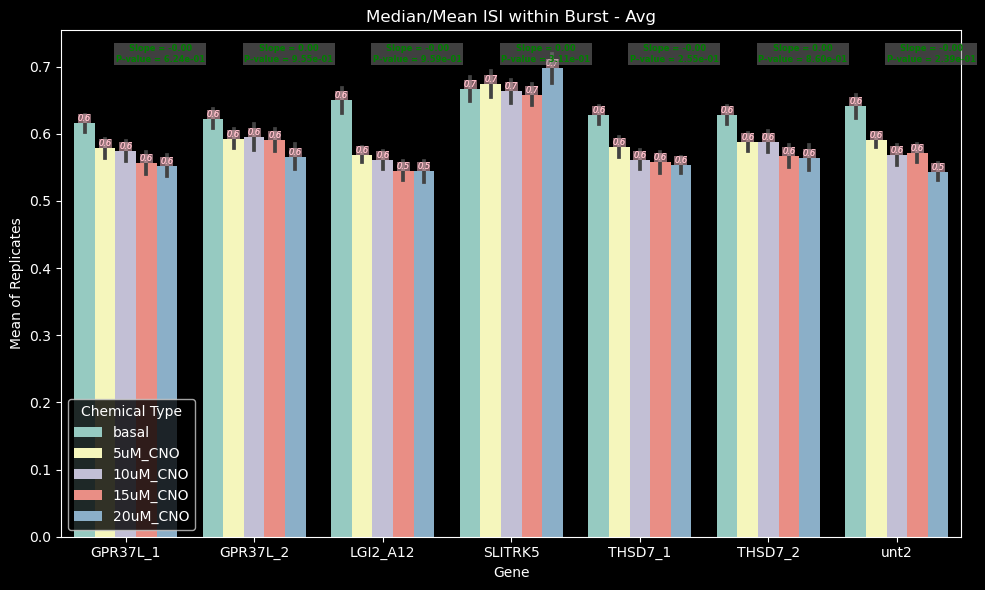

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0019717693875254154, 'r': 0.39539377313684126, 'p': 0.05582683640086971, 'se': 0.0009765616198642335}, 'GPR37L_2': {'slope': 0.0007158230406390628, 'r': 0.15573620643487734, 'p': 0.46742723800682473, 'se': 0.0009679951539194241}, 'LGI2_A12': {'slope': 0.0016265034782608696, 'r': 0.4141315491101849, 'p': 0.04423236634128478, 'se': 0.0007621672802967326}, 'SLITRK5': {'slope': 0.0006631663078634793, 'r': 0.1521175244015213, 'p': 0.4779620677170239, 'se': 0.0009186457819288029}, 'THSD7_1': {'slope': 0.0013767599999999999, 'r': 0.28348447441219415, 'p': 0.17947349515864472, 'se': 0.000992946233485289}, 'THSD7_2': {'slope': -0.0016812252173913043, 'r': -0.17631907033711497, 'p': 0.40984990549358125, 'se': 0.002001047243840527}, 'unt2': {'slope': 0.0019350630434782608, 'r': 0.3740316018239107, 'p': 0.07177282922033827, 'se': 0.0010229397289125374}}
[0.26857143 1.26857143 2.2

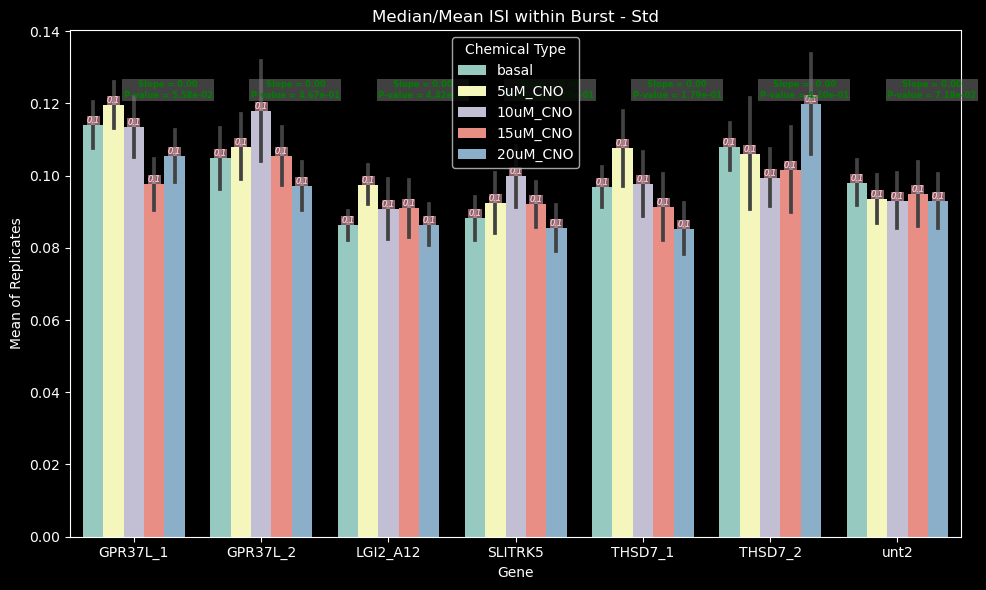

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.30199895356527107, 'r': 0.5077073937691106, 'p': 0.011319870487897277, 'se': 0.1092573841716601}, 'GPR37L_2': {'slope': 0.0514129404234363, 'r': 0.12953677294699217, 'p': 0.5463281294291558, 'se': 0.08390607974426202}, 'LGI2_A12': {'slope': 0.48877462478260875, 'r': 0.47355400856177576, 'p': 0.01941619683759062, 'se': 0.1938151555352841}, 'SLITRK5': {'slope': 0.0684463152173913, 'r': 0.059879357880736665, 'p': 0.7810607070405959, 'se': 0.24326610933887668}, 'THSD7_1': {'slope': 0.2784000086956522, 'r': 0.3090382822495518, 'p': 0.14172474085531367, 'se': 0.18266224448574395}, 'THSD7_2': {'slope': 0.019904924978090474, 'r': 0.026027996393661004, 'p': 0.9039099015810109, 'se': 0.16299013110186789}, 'unt2': {'slope': 0.1554335022249064, 'r': 0.228859737883192, 'p': 0.2820685431522852, 'se': 0.1409554080175992}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.268

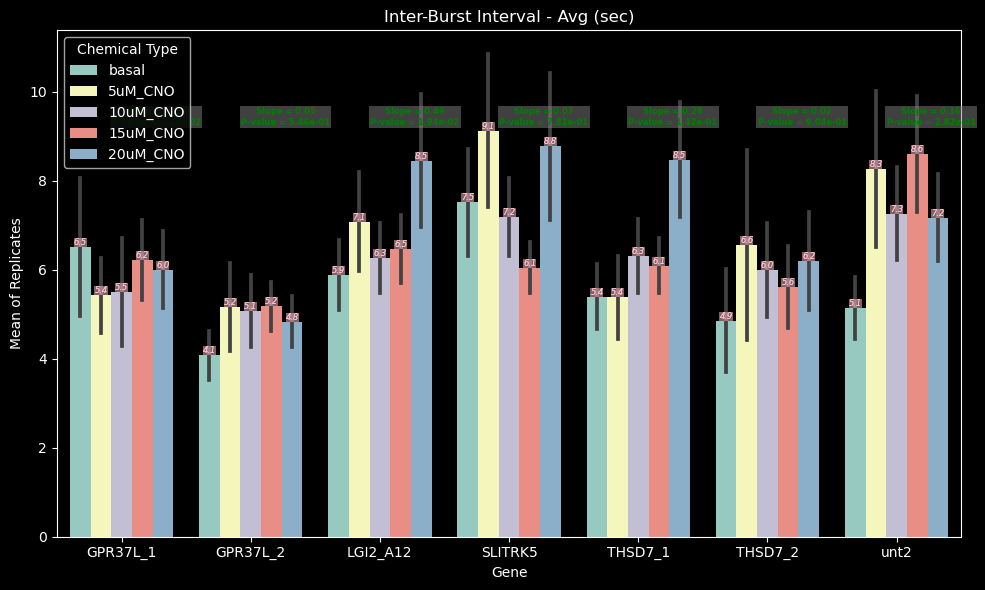

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0024018533050890888, 'r': 0.030570709426819817, 'p': 0.8872356475582626, 'se': 0.016742742105188287}, 'GPR37L_2': {'slope': -0.05282561323327788, 'r': -0.2429756729938192, 'p': 0.2526087882721722, 'se': 0.04496314134362337}, 'LGI2_A12': {'slope': 0.11640813173913042, 'r': 0.4464354842394053, 'p': 0.02875449297568471, 'se': 0.04974471278874658}, 'SLITRK5': {'slope': -0.05060157130434783, 'r': -0.30655632294473006, 'p': 0.14511905482487994, 'se': 0.03349747322378757}, 'THSD7_1': {'slope': 0.04110906347826087, 'r': 0.14295790119940852, 'p': 0.5051576495770254, 'se': 0.06067842142820322}, 'THSD7_2': {'slope': -0.17448772701607576, 'r': -0.341811201599902, 'p': 0.1020897160866572, 'se': 0.10227940757663682}, 'unt2': {'slope': -0.06652147188760062, 'r': -0.4152320460552229, 'p': 0.043615322274498214, 'se': 0.031071717211776758}}
[0.26857143 1.26857143 2.26857143 3.26857143 

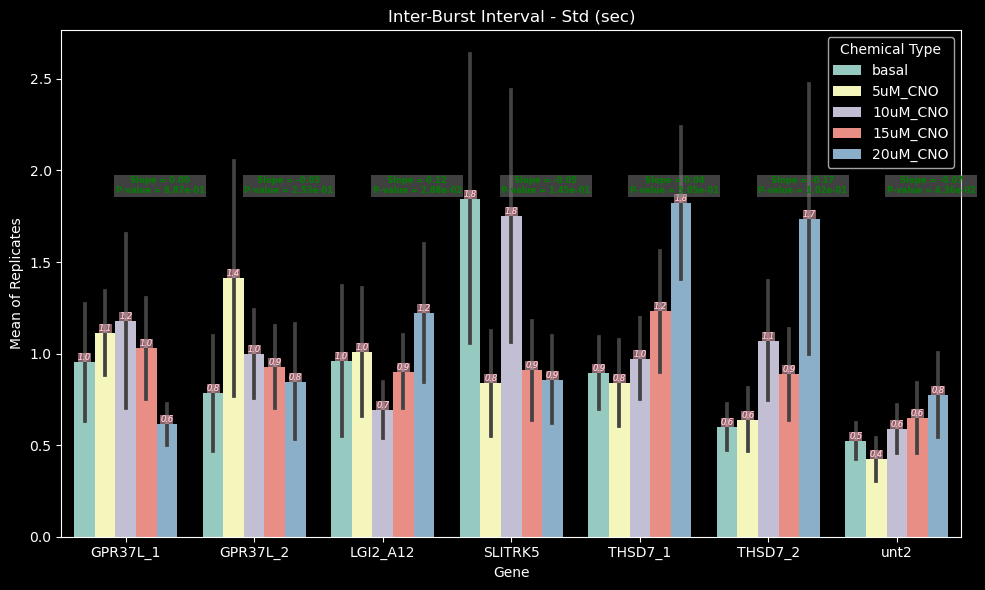

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.0013919212152639928, 'r': -0.09373188148423214, 'p': 0.6630989872055091, 'se': 0.00315209839697027}, 'GPR37L_2': {'slope': -0.0012036759600989335, 'r': -0.06942309307331522, 'p': 0.7471985116379256, 'se': 0.003687611847566251}, 'LGI2_A12': {'slope': -0.0033375991304347825, 'r': -0.20751568276821192, 'p': 0.3305576912702092, 'se': 0.0033543906419815114}, 'SLITRK5': {'slope': -0.0028199952173913042, 'r': -0.23267146638109246, 'p': 0.2739087260622359, 'se': 0.0025130912034691125}, 'THSD7_1': {'slope': 0.0009987017391304349, 'r': 0.0746947876046384, 'p': 0.7286824099450838, 'se': 0.002842622862433827}, 'THSD7_2': {'slope': 0.0015487352173913038, 'r': 0.10364372687802251, 'p': 0.6298454064801111, 'se': 0.0031686742393237325}, 'unt2': {'slope': -0.0023541508695652177, 'r': -0.2180403806999172, 'p': 0.3060554004950325, 'se': 0.002246513466333616}}
[0.26857143 1.26857143 2.2

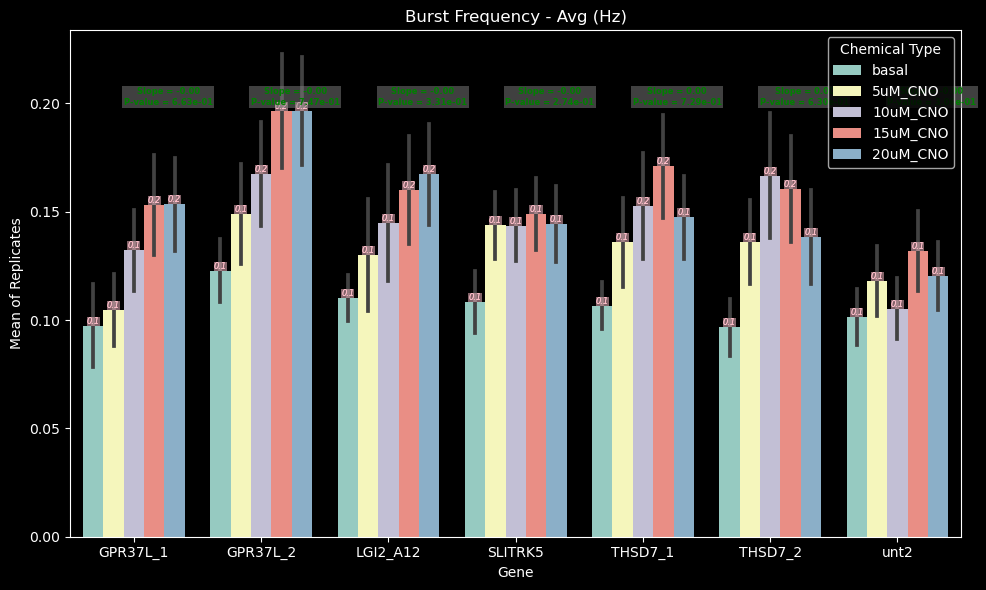

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.0005487722443710801, 'r': -0.15868633606753996, 'p': 0.45892817567043775, 'se': 0.0007279527289345844}, 'GPR37L_2': {'slope': -0.0013754319927620647, 'r': -0.21957863128584676, 'p': 0.3025706413746663, 'se': 0.0013028883090819773}, 'LGI2_A12': {'slope': -0.00033509, 'r': -0.16569725135700006, 'p': 0.43905773896205613, 'se': 0.0004251963680879434}, 'SLITRK5': {'slope': -0.0007457617313510232, 'r': -0.18594685599655378, 'p': 0.3843315531133825, 'se': 0.0008401540142452816}, 'THSD7_1': {'slope': 0.0003219417391304348, 'r': 0.07699638452327386, 'p': 0.7206436267155534, 'se': 0.0008888007991726131}, 'THSD7_2': {'slope': -0.0007384095652173912, 'r': -0.15694872562691561, 'p': 0.4639242963992347, 'se': 0.0009906317208134127}, 'unt2': {'slope': -0.001090226086956522, 'r': -0.5956347725563985, 'p': 0.0021334036493362977, 'se': 0.00031345762077475116}}
[0.26857143 1.26857143 2

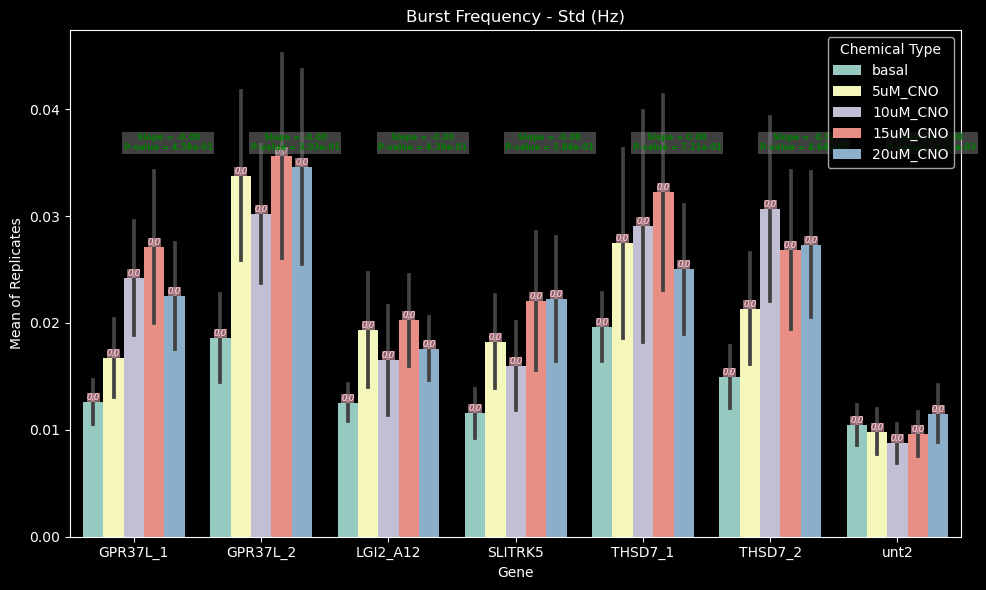

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.026363627414285145, 'r': -0.3067236285114635, 'p': 0.14488844610171334, 'se': 0.017441814492191194}, 'GPR37L_2': {'slope': -0.026604086150113126, 'r': -0.2799829891864318, 'p': 0.1851398757651615, 'se': 0.019448174236171907}, 'LGI2_A12': {'slope': -0.008213159305463187, 'r': -0.09375413841710052, 'p': 0.6630235909379993, 'se': 0.01859479230916282}, 'SLITRK5': {'slope': -0.005746106439873164, 'r': -0.10022302670249078, 'p': 0.641247074984576, 'se': 0.01216193321855934}, 'THSD7_1': {'slope': -0.020555196956521738, 'r': -0.34457613529371595, 'p': 0.09916780685699633, 'se': 0.01193930181607575}, 'THSD7_2': {'slope': -0.03476117682986413, 'r': -0.43566594029326694, 'p': 0.03333703376871965, 'se': 0.015311733146805971}, 'unt2': {'slope': -0.01577530449432091, 'r': -0.22214789159912007, 'p': 0.2968051951087368, 'se': 0.014761640098773923}}
[0.26857143 1.26857143 2.26857143 

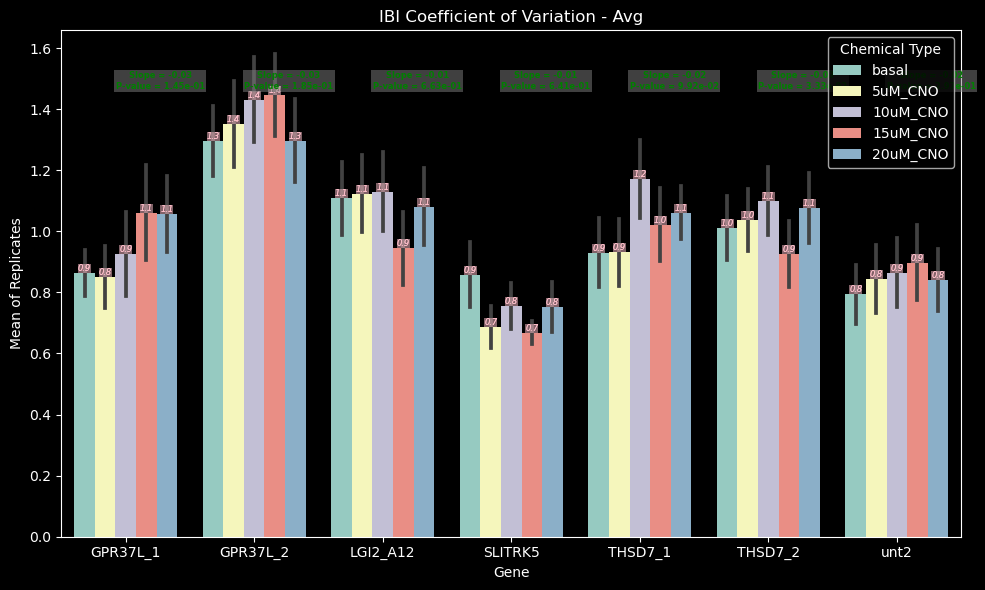

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.0034190154980091756, 'r': -0.2745395435587276, 'p': 0.19419112124783053, 'se': 0.002553103090138808}, 'GPR37L_2': {'slope': -0.006249484107844703, 'r': -0.32397343492436287, 'p': 0.12248968040134235, 'se': 0.0038908540818235063}, 'LGI2_A12': {'slope': 1.182330794026536e-05, 'r': 0.0006695732128855084, 'p': 0.9975224903520519, 'se': 0.0037646923577414693}, 'SLITRK5': {'slope': -0.0009452651104430045, 'r': -0.08867937559894999, 'p': 0.68029544949301, 'se': 0.0022636290502257394}, 'THSD7_1': {'slope': -0.006671887391304347, 'r': -0.3580072830564574, 'p': 0.08585005614309439, 'se': 0.0037098948939494054}, 'THSD7_2': {'slope': -0.005248881473011597, 'r': -0.24836570754089843, 'p': 0.24190706997205602, 'se': 0.0043645352163679575}, 'unt2': {'slope': -0.009550683782978246, 'r': -0.46739842721543357, 'p': 0.021282551840685594, 'se': 0.0038513334880470682}}
[0.26857143 1.2685

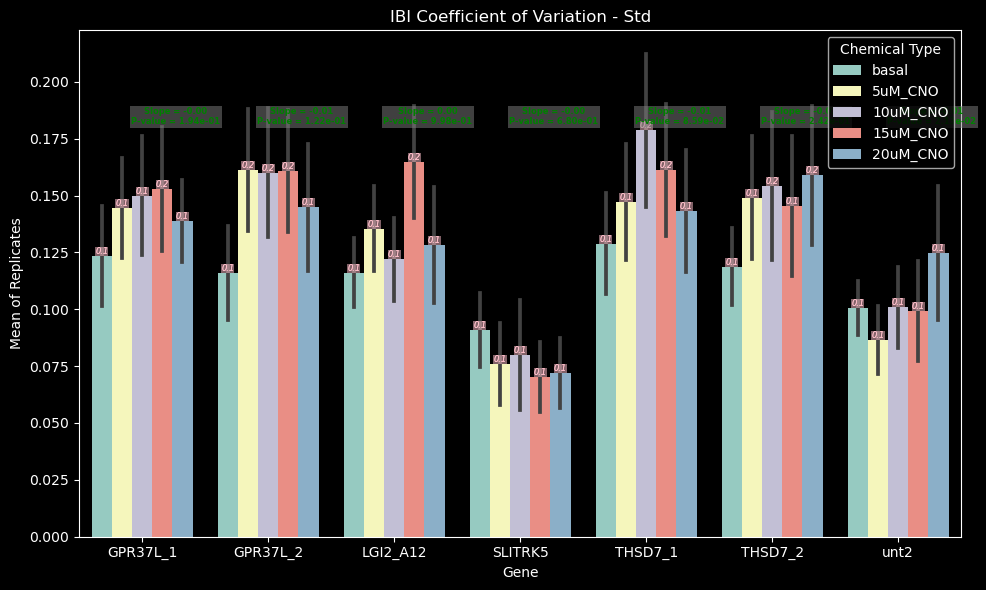

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.13970318963174613, 'r': 0.32891576254924365, 'p': 0.11656335901315554, 'se': 0.08551603183202633}, 'GPR37L_2': {'slope': -0.20131565391304362, 'r': -0.07076555097192276, 'p': 0.7424699658183067, 'se': 0.6049983071303929}, 'LGI2_A12': {'slope': -0.14817317478260864, 'r': -0.285550106428014, 'p': 0.1761875308045691, 'se': 0.10602451920737714}, 'SLITRK5': {'slope': 0.39792901608695647, 'r': 0.15948036738054822, 'p': 0.45665448372542927, 'se': 0.5251612470868288}, 'THSD7_1': {'slope': -0.043663736086956215, 'r': -0.0495646846815439, 'p': 0.8180957128108857, 'se': 0.18758715312275234}, 'THSD7_2': {'slope': 0.782539170869565, 'r': 0.45225756406527395, 'p': 0.026495801595959375, 'se': 0.32901744404285804}, 'unt2': {'slope': -0.008136110434782602, 'r': -0.013921438133469058, 'p': 0.9485220164285371, 'se': 0.1245888864041078}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.268

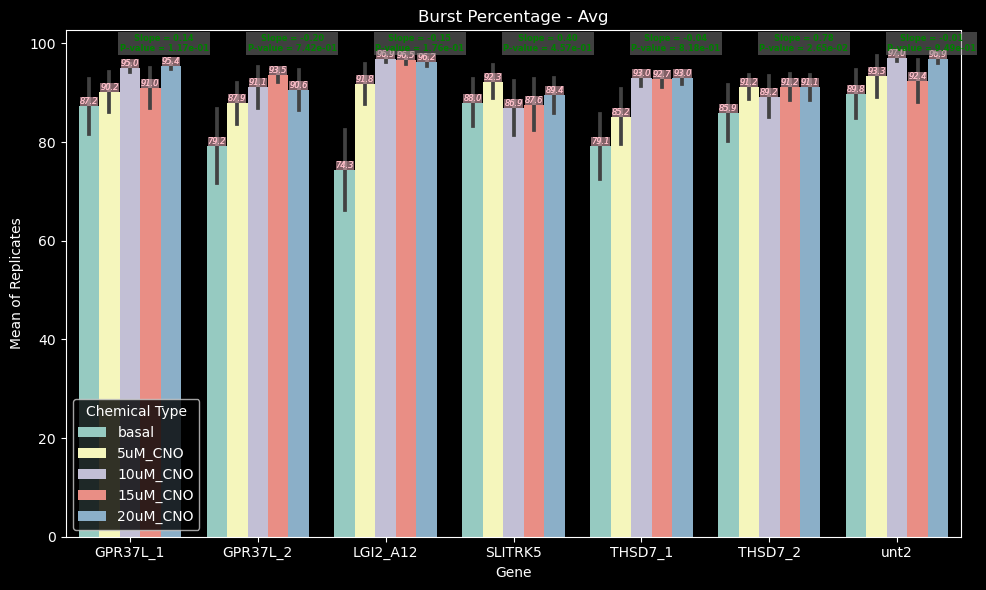

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.1864989908735628, 'r': -0.30038920708856925, 'p': 0.15380292253327885, 'se': 0.12625417542027786}, 'GPR37L_2': {'slope': -0.5150948883610369, 'r': -0.36098208823708855, 'p': 0.08309147904151447, 'se': 0.2837089048537372}, 'LGI2_A12': {'slope': 0.3219389152173914, 'r': 0.29389150033391476, 'p': 0.1633428768286253, 'se': 0.2232337010409596}, 'SLITRK5': {'slope': 0.09438183190291718, 'r': 0.05006300034977547, 'p': 0.8162971221629234, 'se': 0.40143503074807596}, 'THSD7_1': {'slope': 0.11927911608695647, 'r': 0.07493746629463281, 'p': 0.7278334800335242, 'se': 0.33840066875098523}, 'THSD7_2': {'slope': -0.7856912417391303, 'r': -0.42215895338738474, 'p': 0.039885006657160785, 'se': 0.3597019823430132}, 'unt2': {'slope': 0.23235017869565217, 'r': 0.21956953531172999, 'p': 0.30259117501014554, 'se': 0.22010503547988292}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.268571

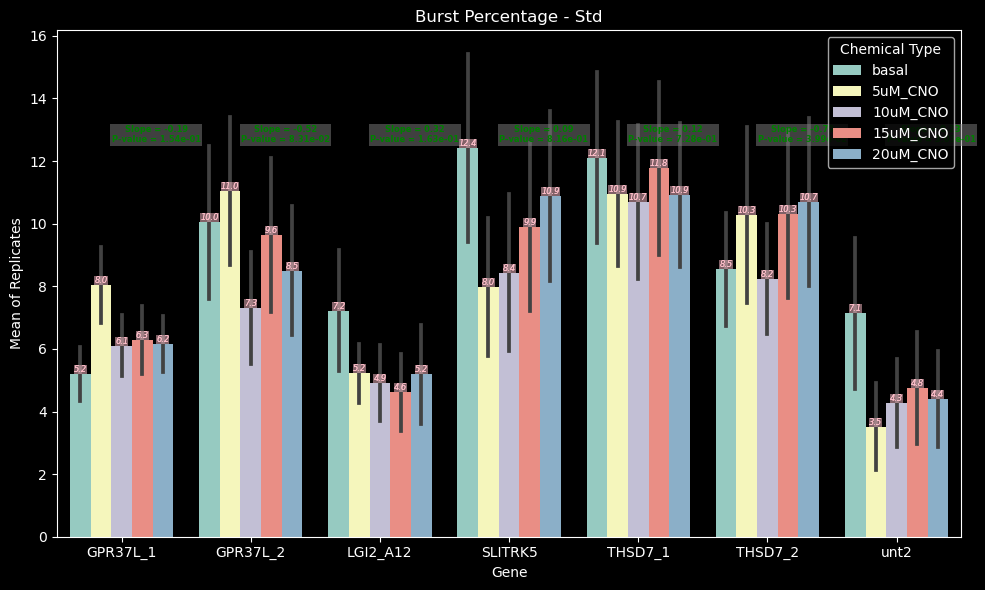

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.09695652173913043, 'r': -0.17078848726784612, 'p': 0.4249215195214705, 'se': 0.11925565387547987}, 'GPR37L_2': {'slope': 0.05173913043478261, 'r': 0.06320428148637307, 'p': 0.769216221958615, 'se': 0.17417751629692288}, 'LGI2_A12': {'slope': -0.16130434782608696, 'r': -0.1812365294843397, 'p': 0.3967012508643647, 'se': 0.18661075051023152}, 'SLITRK5': {'slope': -0.20521739130434782, 'r': -0.26145271468332526, 'p': 0.21717332304009357, 'se': 0.16152297596598467}, 'THSD7_1': {'slope': -0.010869565217391308, 'r': -0.019703933044043328, 'p': 0.9271869808894082, 'se': 0.11758815779020736}, 'THSD7_2': {'slope': 0.1565217391304348, 'r': 0.198296700322163, 'p': 0.3529606611217412, 'se': 0.16494412599980274}, 'unt2': {'slope': -0.07956521739130436, 'r': -0.1343022055620835, 'p': 0.5315346611867489, 'se': 0.1251631003296825}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.2685

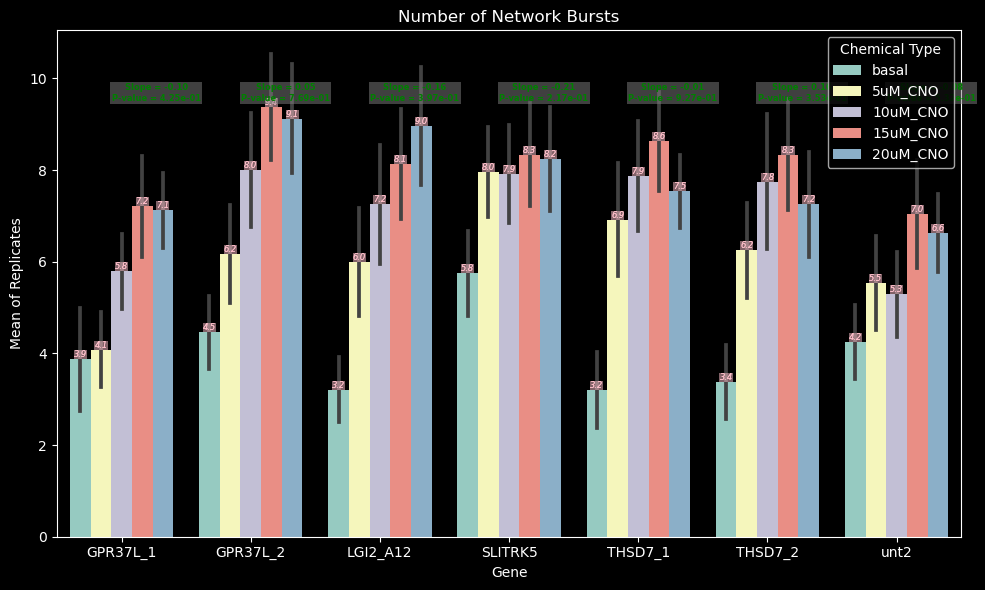

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.001207870118649107, 'r': -0.13299567217708055, 'p': 0.5355717006619394, 'se': 0.0019190935526523791}, 'GPR37L_2': {'slope': 0.0015254445927865923, 'r': 0.11819090522315293, 'p': 0.5822926799546928, 'se': 0.0027324127498842307}, 'LGI2_A12': {'slope': -0.002688398695652174, 'r': -0.1812360320111946, 'p': 0.39670256894278666, 'se': 0.0031101797866208633}, 'SLITRK5': {'slope': -0.0043301325458962635, 'r': -0.3709371046165732, 'p': 0.07434402581580328, 'se': 0.0023112417418447305}, 'THSD7_1': {'slope': -0.00018117304347826086, 'r': -0.019705422850460376, 'p': 0.9271814897661581, 'se': 0.0019598017696155685}, 'THSD7_2': {'slope': 0.002608697826086956, 'r': 0.19829692230372759, 'p': 0.35296011118214965, 'se': 0.002749067854170952}, 'unt2': {'slope': -0.0013260856521739135, 'r': -0.13430223733526364, 'p': 0.5315345631859818, 'se': 0.002086049117725208}}
[0.26857143 1.2685714

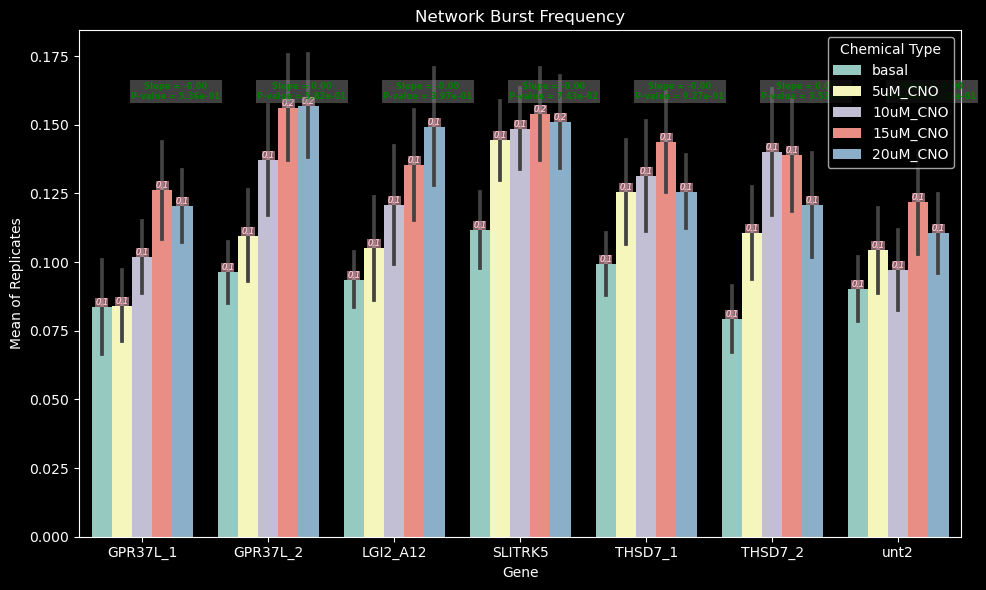

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.00871844675096325, 'r': 0.44521301784114287, 'p': 0.029247766062406037, 'se': 0.003738427717276205}, 'GPR37L_2': {'slope': -0.004498004926212405, 'r': -0.20951256044605435, 'p': 0.325820530519902, 'se': 0.004475599329538503}, 'LGI2_A12': {'slope': 0.004697649130434783, 'r': 0.1618719762661759, 'p': 0.44984187895906524, 'se': 0.0061056497309435985}, 'SLITRK5': {'slope': 0.005946245563865619, 'r': 0.23395103538672748, 'p': 0.27120352529029035, 'se': 0.005268460845389909}, 'THSD7_1': {'slope': 0.0018151578260869555, 'r': 0.08285801424562791, 'p': 0.700301705653536, 'se': 0.004654495089140658}, 'THSD7_2': {'slope': -0.0064148234782608685, 'r': -0.25568605616637313, 'p': 0.22785458786344923, 'se': 0.00517112384014334}, 'unt2': {'slope': -0.011428175652173913, 'r': -0.33326077977606783, 'p': 0.11152863760842026, 'se': 0.006893137055485375}}
[0.26857143 1.26857143 2.26857143

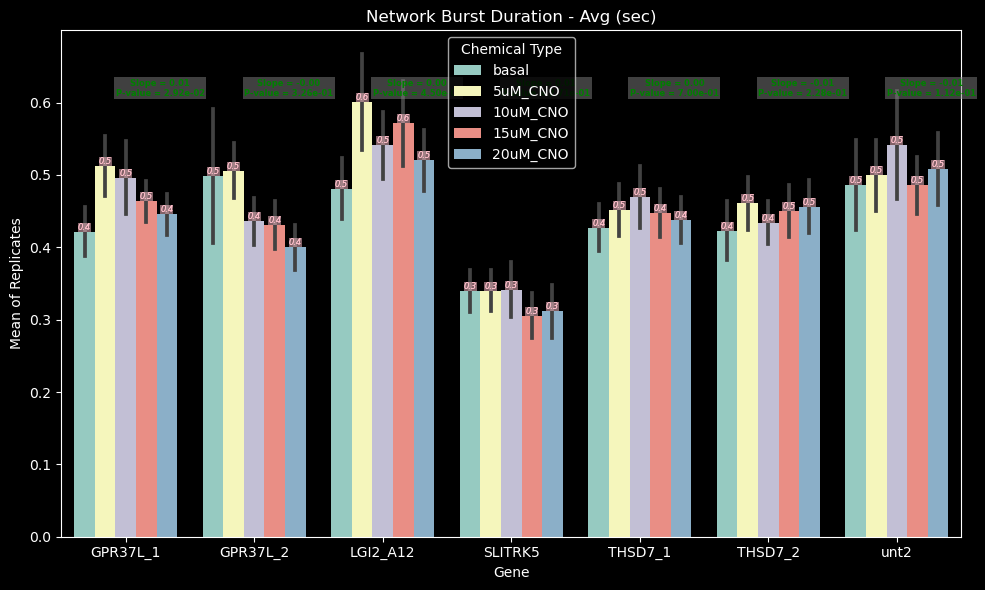

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.004058324891988974, 'r': -0.18481109130031587, 'p': 0.38729389018623595, 'se': 0.0046010942174582225}, 'GPR37L_2': {'slope': -0.010317168862781287, 'r': -0.5320981842378445, 'p': 0.007442272886353646, 'se': 0.003500080924227039}, 'LGI2_A12': {'slope': -0.0013771513043478263, 'r': -0.07329266542615438, 'p': 0.7335932962747005, 'se': 0.003995215246681023}, 'SLITRK5': {'slope': 0.0014091712380904173, 'r': 0.1452072278405691, 'p': 0.4984098572615083, 'se': 0.002047088678726337}, 'THSD7_1': {'slope': 0.00037522695652173914, 'r': 0.023272145585607265, 'p': 0.9140450759972523, 'se': 0.0034365971694257456}, 'THSD7_2': {'slope': -0.0056236685353448215, 'r': -0.26169386642860576, 'p': 0.2167340776854767, 'se': 0.004421911688806128}, 'unt2': {'slope': -0.009868295397099958, 'r': -0.5514203875832303, 'p': 0.005220937103034584, 'se': 0.0031829696267425874}}
[0.26857143 1.26857143

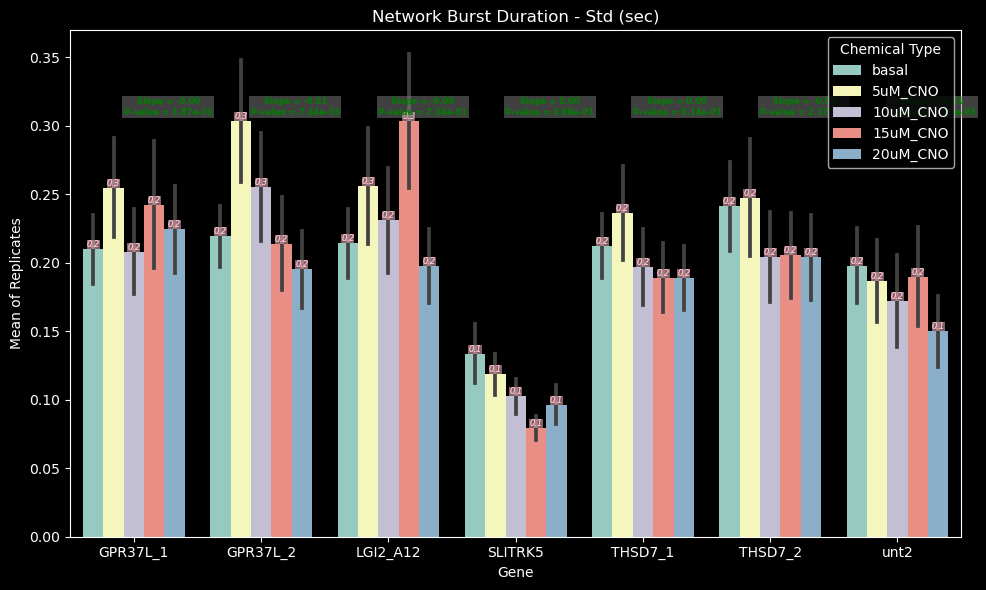

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 2.2753650252736803, 'r': 0.3153030652972322, 'p': 0.1334099951142178, 'se': 1.460069916800044}, 'GPR37L_2': {'slope': -0.16467587838671782, 'r': -0.01616013174472533, 'p': 0.9402572955502202, 'se': 2.1722861630434056}, 'LGI2_A12': {'slope': 1.3603587330434785, 'r': 0.12828383682297995, 'p': 0.5502488834475996, 'se': 2.2421615490713735}, 'SLITRK5': {'slope': 4.34010501934965, 'r': 0.3202380956701452, 'p': 0.12711173939785192, 'se': 2.737287691572975}, 'THSD7_1': {'slope': 0.40877128478260866, 'r': 0.042759053198185466, 'p': 0.8427450857034358, 'se': 2.036308517342746}, 'THSD7_2': {'slope': -0.727721152173913, 'r': -0.06486714931423246, 'p': 0.7633110906558384, 'se': 2.386784545071497}, 'unt2': {'slope': -3.007195298695652, 'r': -0.23157375885875997, 'p': 0.2762430582093905, 'se': 2.693346662107296}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26

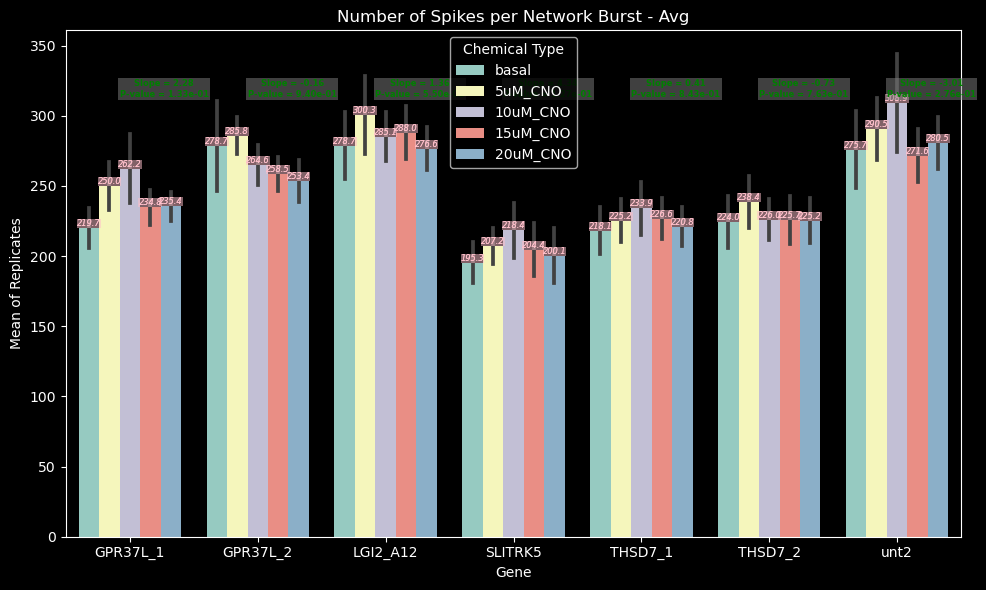

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -3.6287740281584866, 'r': -0.3154041711324178, 'p': 0.13327875017417676, 'se': 2.327704699415759}, 'GPR37L_2': {'slope': -4.5041344779068835, 'r': -0.46295170828203824, 'p': 0.022719051467258652, 'se': 1.8385946079532476}, 'LGI2_A12': {'slope': -2.31718687, 'r': -0.22667536814420827, 'p': 0.28681299484959794, 'se': 2.1227122827432883}, 'SLITRK5': {'slope': 0.12952574579258355, 'r': 0.04018926801609224, 'p': 0.8520912987299636, 'se': 0.6865681460171521}, 'THSD7_1': {'slope': -1.5690620165217393, 'r': -0.17930636430702293, 'p': 0.40183378083917165, 'se': 1.8354261630292152}, 'THSD7_2': {'slope': -2.167812684261869, 'r': -0.23402999578558992, 'p': 0.27103715071772916, 'se': 1.9200282886793094}, 'unt2': {'slope': -2.7090193727025484, 'r': -0.36127478667040785, 'p': 0.08282370711726347, 'se': 1.490709597109997}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857

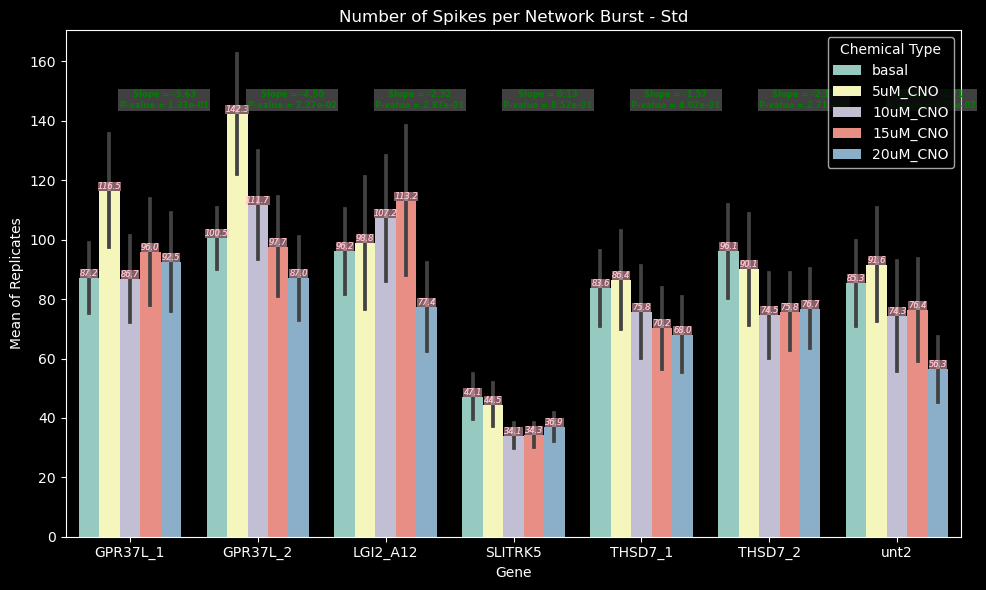

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 1.6709595228547842e-05, 'r': 0.21542152645676227, 'p': 0.31204481231083425, 'se': 1.6149056219588962e-05}, 'GPR37L_2': {'slope': -1.58242312459256e-05, 'r': -0.24121952005503294, 'p': 0.2561607679123665, 'se': 1.3573167382211112e-05}, 'LGI2_A12': {'slope': 6.52565217391304e-06, 'r': 0.06894069493781789, 'p': 0.7488998380985048, 'se': 2.0132717623400763e-05}, 'SLITRK5': {'slope': -3.24502460308489e-06, 'r': -0.05153787013217747, 'p': 0.8109791188707063, 'se': 1.3406105821807753e-05}, 'THSD7_1': {'slope': 5.549130434782608e-06, 'r': 0.07117786538754307, 'p': 0.741019472354328, 'se': 1.6579281539981373e-05}, 'THSD7_2': {'slope': -1.396782608695653e-05, 'r': -0.13247304967209922, 'p': 0.5371905562933115, 'se': 2.2281548499602243e-05}, 'unt2': {'slope': -2.546260869565218e-05, 'r': -0.3432115176303375, 'p': 0.10060204356268215, 'se': 1.4856437134399002e-05}}
[0.26857143 1.26

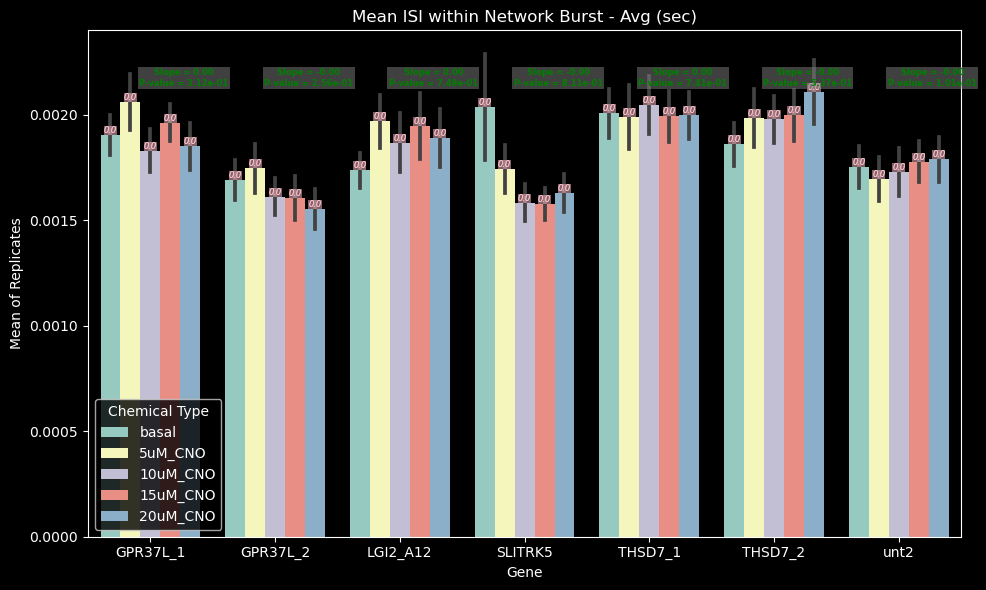

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -1.1148972366671699e-05, 'r': -0.3034680388358989, 'p': 0.14942289348873863, 'se': 7.463306176305823e-06}, 'GPR37L_2': {'slope': -4.0640242629203975e-06, 'r': -0.1481993092200793, 'p': 0.4895034887908901, 'se': 5.781977628082478e-06}, 'LGI2_A12': {'slope': -8.466956521739126e-06, 'r': -0.15436928375344017, 'p': 0.47139253441029016, 'se': 1.1553614057960795e-05}, 'SLITRK5': {'slope': 1.7594116547254098e-05, 'r': 0.2607818208620618, 'p': 0.21839845162964028, 'se': 1.388625381564211e-05}, 'THSD7_1': {'slope': -3.418260869565218e-06, 'r': -0.10879019407847688, 'p': 0.6128456125108572, 'se': 6.659149697808944e-06}, 'THSD7_2': {'slope': 1.943951330192728e-05, 'r': 0.23678947240490988, 'p': 0.2652636044478489, 'se': 1.700519918660752e-05}, 'unt2': {'slope': -1.6748560516988025e-05, 'r': -0.5143011285168667, 'p': 0.010136362477629819, 'se': 5.954404570171299e-06}}
[0.26857143 1

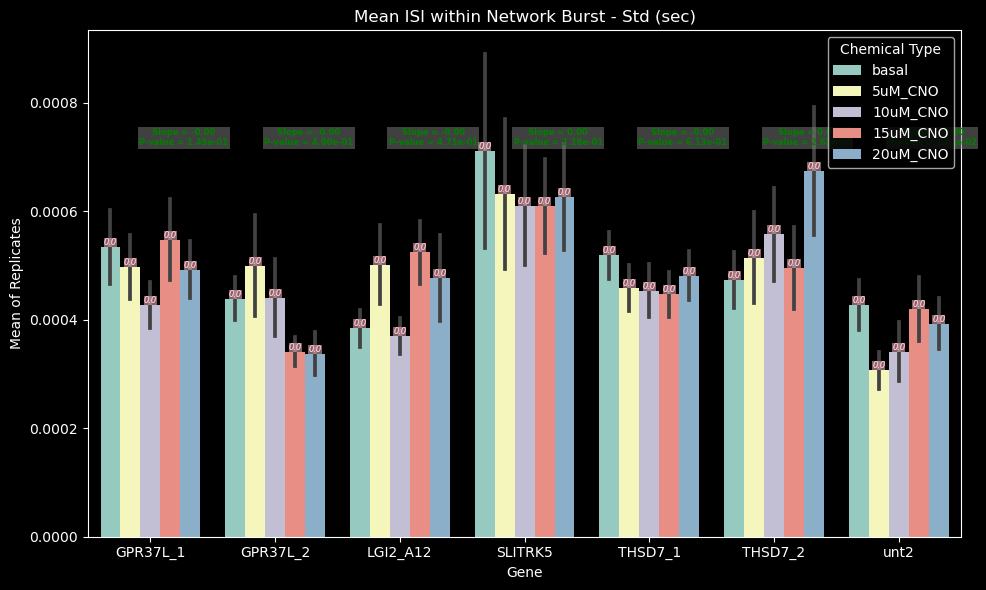

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 4.23249309671004e-06, 'r': 0.14984629387288664, 'p': 0.4846352418805382, 'se': 5.9539822149491175e-06}, 'GPR37L_2': {'slope': -1.2456385696317765e-06, 'r': -0.0647287994028602, 'p': 0.763801911911924, 'se': 4.094222459805682e-06}, 'LGI2_A12': {'slope': 1.2146086956521741e-05, 'r': 0.29830453703812915, 'p': 0.1568196654206738, 'se': 8.285673360240214e-06}, 'SLITRK5': {'slope': -4.855871621039803e-06, 'r': -0.1578637059949752, 'p': 0.46128996654307275, 'se': 6.475800705698102e-06}, 'THSD7_1': {'slope': 2.152608695652176e-06, 'r': 0.11844983435895289, 'p': 0.5814605919462736, 'se': 3.8472557961518795e-06}, 'THSD7_2': {'slope': 2.5986956521739116e-06, 'r': 0.06320448167780232, 'p': 0.7692155102872402, 'se': 8.748367262784774e-06}, 'unt2': {'slope': 1.5465217391304337e-06, 'r': 0.05989124520920864, 'p': 0.781018274472366, 'se': 5.495421987703615e-06}}
[0.26857143 1.26857143 

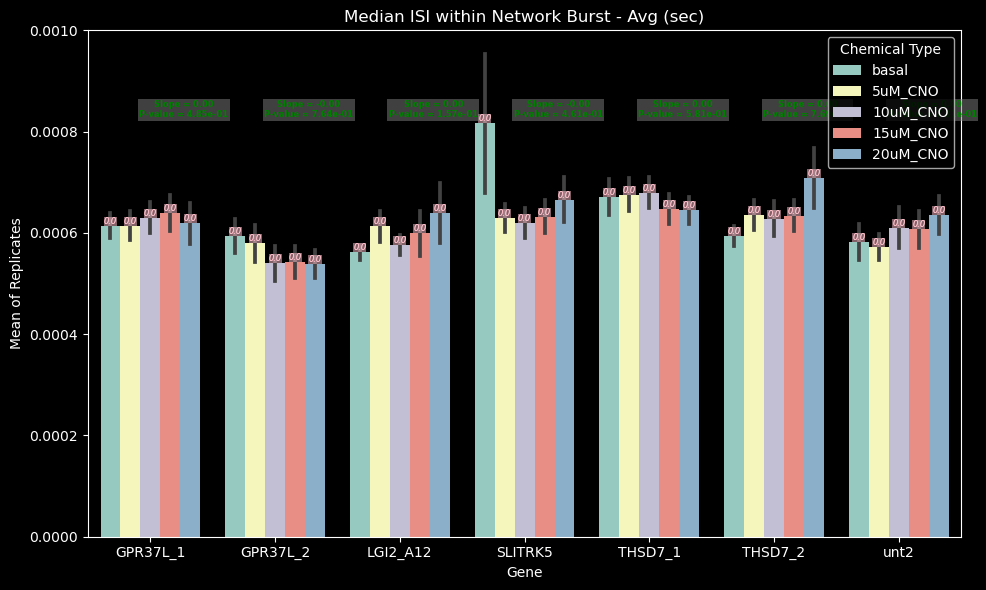

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -4.8378777648866505e-06, 'r': -0.18076915109836464, 'p': 0.39794067486649853, 'se': 5.611834829370932e-06}, 'GPR37L_2': {'slope': -8.751819159311181e-07, 'r': -0.08663525531454284, 'p': 0.6872974777956619, 'se': 2.145637509941574e-06}, 'LGI2_A12': {'slope': 1.235652173913044e-06, 'r': 0.0413728595769861, 'p': 0.8477841431762769, 'se': 6.362053921693659e-06}, 'SLITRK5': {'slope': -1.5205608542770153e-06, 'r': -0.03246347479517429, 'p': 0.8803014321241254, 'se': 9.980872195460555e-06}, 'THSD7_1': {'slope': -6.343478260869565e-07, 'r': -0.0766106967365928, 'p': 0.7219887429730825, 'se': 1.7601450891755292e-06}, 'THSD7_2': {'slope': 1.2245102368993701e-05, 'r': 0.2929650583245701, 'p': 0.16473610563415608, 'se': 8.520186221793463e-06}, 'unt2': {'slope': -4.457305126986219e-06, 'r': -0.29471901097352887, 'p': 0.16210542674909334, 'se': 3.081213022402222e-06}}
[0.26857143 1.2

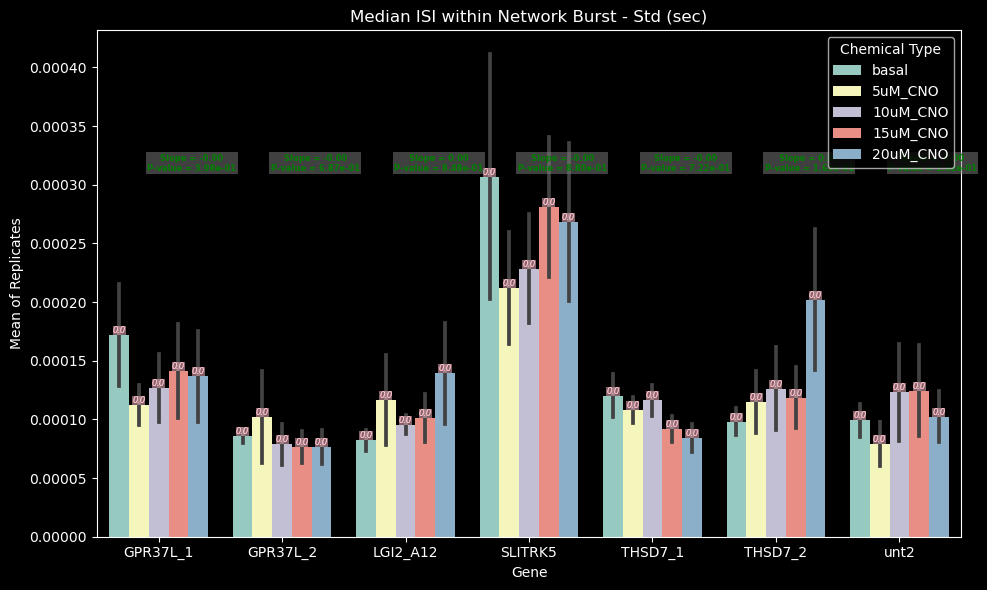

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.00019028474253355418, 'r': -0.017849056096647234, 'p': 0.9340261035697377, 'se': 0.002272522440157469}, 'GPR37L_2': {'slope': 0.0021963464556790948, 'r': 0.21236759425380497, 'p': 0.31911929205203676, 'se': 0.0021546672353165786}, 'LGI2_A12': {'slope': 0.0036941582608695646, 'r': 0.3243233651048145, 'p': 0.12206302283474521, 'se': 0.00229716605641364}, 'SLITRK5': {'slope': -0.0007638503365855036, 'r': -0.07419163646375042, 'p': 0.7304435004636594, 'se': 0.002188988180664989}, 'THSD7_1': {'slope': -9.438826086956513e-05, 'r': -0.010076332012821366, 'p': 0.9627287950268268, 'se': 0.001997018675026139}, 'THSD7_2': {'slope': 0.002831221304347826, 'r': 0.26207513426090495, 'p': 0.2160408315975969, 'se': 0.002222722971227762}, 'unt2': {'slope': 0.0046775247826086955, 'r': 0.49992522826880215, 'p': 0.012861008755943707, 'se': 0.001727634948347898}}
[0.26857143 1.26857143 2.

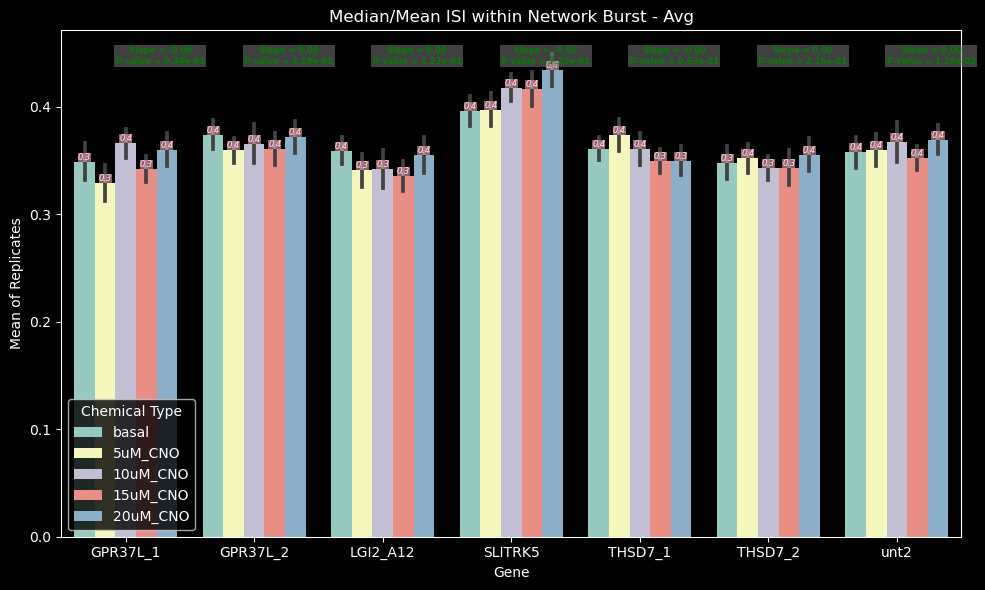

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.003104415485202748, 'r': -0.5260214842733006, 'p': 0.008285411790129881, 'se': 0.001070100755225037}, 'GPR37L_2': {'slope': -0.0009858871155602749, 'r': -0.18741064860844764, 'p': 0.3805327214649701, 'se': 0.001101685465520802}, 'LGI2_A12': {'slope': -0.0016556056521739128, 'r': -0.3850107496884242, 'p': 0.06319369803968979, 'se': 0.0008461221007235715}, 'SLITRK5': {'slope': 0.00120827897452028, 'r': 0.1838438392025397, 'p': 0.38982688257012355, 'se': 0.0013773383436150007}, 'THSD7_1': {'slope': -0.0013316852173913044, 'r': -0.22032423247056598, 'p': 0.30089042058172255, 'se': 0.0012569633312558563}, 'THSD7_2': {'slope': 0.0007587269634083343, 'r': 0.1802069064288644, 'p': 0.3994345425275043, 'se': 0.0008829456066655666}, 'unt2': {'slope': -0.0007896249151401831, 'r': -0.18930507209107375, 'p': 0.3756483031807285, 'se': 0.0008732178725135336}}
[0.26857143 1.26857143 

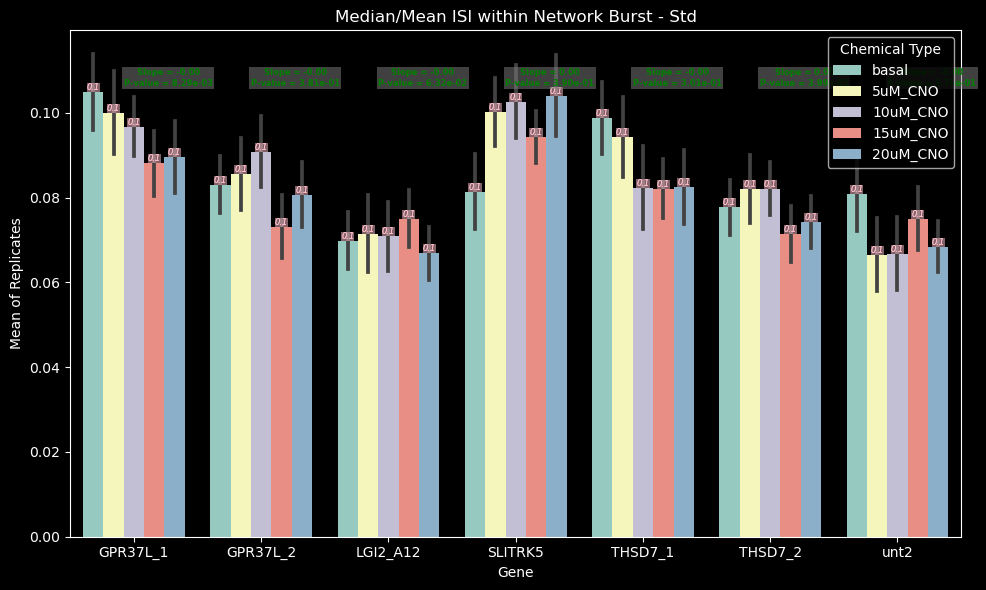

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.0014403196226851548, 'r': -0.05921920812945932, 'p': 0.7834181016528768, 'se': 0.005176331555289138}, 'GPR37L_2': {'slope': 0.028786435514402204, 'r': 0.24585197278264861, 'p': 0.2468604694536757, 'se': 0.024197158843234083}, 'LGI2_A12': {'slope': -0.009774845652173911, 'r': -0.3477182986878512, 'p': 0.09592308161284922, 'se': 0.005619377163117462}, 'SLITRK5': {'slope': 0.008309480723629251, 'r': 0.1828279941289824, 'p': 0.39249718400923983, 'se': 0.00952658808166599}, 'THSD7_1': {'slope': -0.009188401739130434, 'r': -0.30521708308041134, 'p': 0.14697444629057468, 'se': 0.00611203366792551}, 'THSD7_2': {'slope': 0.002365147391304341, 'r': 0.0789956653707677, 'p': 0.7136839354973514, 'se': 0.0063633277924890095}, 'unt2': {'slope': 0.003276396086956524, 'r': 0.4017710838260874, 'p': 0.05164334096354844, 'se': 0.001592130385132599}}
[0.26857143 1.26857143 2.26857143 3.2

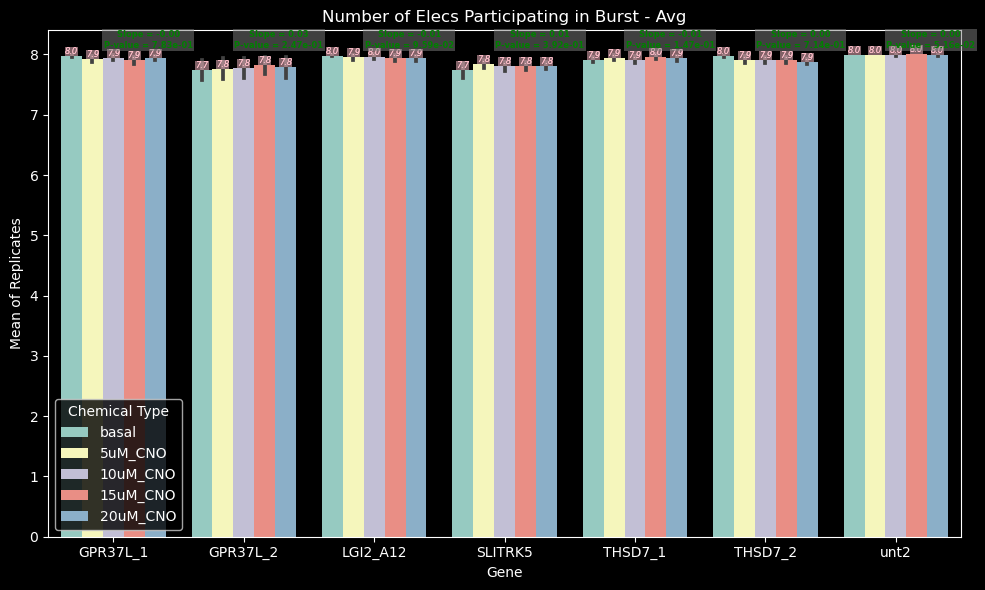

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.006262229781244878, 'r': -0.18636017003198682, 'p': 0.3832567423934613, 'se': 0.007038643023249205}, 'GPR37L_2': {'slope': -0.0023656723325301728, 'r': -0.2582384705341011, 'p': 0.22308477979313868, 'se': 0.0018868437685639317}, 'LGI2_A12': {'slope': 0.01063312652173913, 'r': 0.319417273388919, 'p': 0.12814409472981253, 'se': 0.006725472277456111}, 'SLITRK5': {'slope': -0.0004070523643816585, 'r': -0.011449624100412994, 'p': 0.9576533159011027, 'se': 0.007579128040905666}, 'THSD7_1': {'slope': 0.005867968695652174, 'r': 0.2459279573468315, 'p': 0.2467097784282864, 'se': 0.004930845906152975}, 'THSD7_2': {'slope': 0.008930794968462752, 'r': 0.1520260876282467, 'p': 0.4782298149970421, 'se': 0.012378928718541541}, 'unt2': {'slope': -0.009120485812392132, 'r': -0.4409066701852402, 'p': 0.031039543738319533, 'se': 0.003958403336868471}}
[0.26857143 1.26857143 2.26857143 

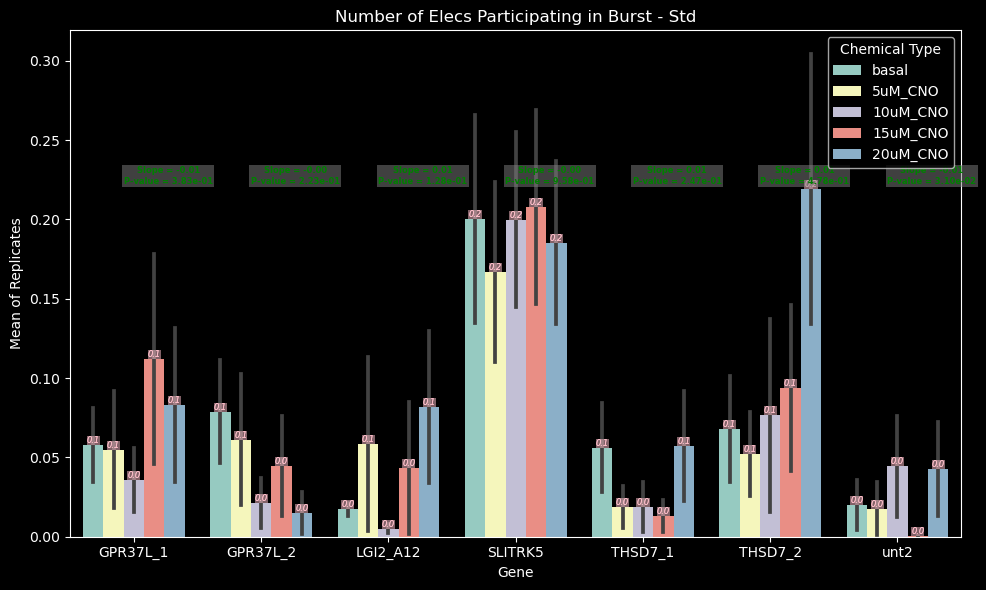

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.29111416647889743, 'r': 0.32256776124548026, 'p': 0.12421448702404343, 'se': 0.18212641376137534}, 'GPR37L_2': {'slope': -0.14623480206151676, 'r': -0.11947098237621986, 'p': 0.578184109843906, 'se': 0.2590927276173153}, 'LGI2_A12': {'slope': 0.2149203391304348, 'r': 0.1613432838518496, 'p': 0.4513432522675729, 'se': 0.28027715843054435}, 'SLITRK5': {'slope': 0.5509237408010779, 'r': 0.3281290434315089, 'p': 0.11749241531050897, 'se': 0.3381415552103841}, 'THSD7_1': {'slope': 0.08688678826086957, 'r': 0.07296304727222956, 'p': 0.7347492541400731, 'se': 0.2532097038513602}, 'THSD7_2': {'slope': -0.10949695043478265, 'r': -0.07835357308654957, 'p': 0.7159167374561163, 'se': 0.2970261186985448}, 'unt2': {'slope': -0.38183692652173906, 'r': -0.23567802885079348, 'p': 0.267579483993618, 'se': 0.33568993686305804}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.2

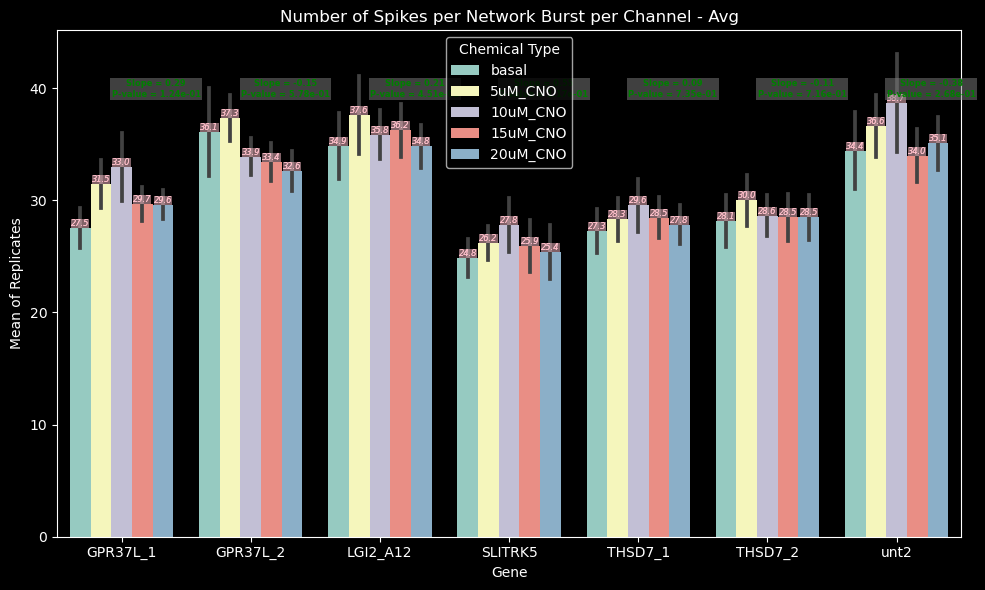

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.4375788529106382, 'r': -0.3032240062496603, 'p': 0.14976679516608637, 'se': 0.29318215247240664}, 'GPR37L_2': {'slope': -0.6123483871339782, 'r': -0.4951874711613875, 'p': 0.013880889080683514, 'se': 0.22905009542226634}, 'LGI2_A12': {'slope': -0.2596999269565217, 'r': -0.20680166418030488, 'p': 0.3322615508468273, 'se': 0.2619481316258637}, 'SLITRK5': {'slope': 0.027232393211878557, 'r': 0.06523763001326331, 'p': 0.7619971796679836, 'se': 0.08880760415280786}, 'THSD7_1': {'slope': -0.15391780173913042, 'r': -0.14070940089041042, 'p': 0.5119473856548221, 'se': 0.23089362300323843}, 'THSD7_2': {'slope': -0.2986816384360147, 'r': -0.25978352001838884, 'p': 0.22022999440776933, 'se': 0.23670799336666087}, 'unt2': {'slope': -0.32344867997416693, 'r': -0.34799927067019865, 'p': 0.09563683430158426, 'se': 0.18577384859957452}}
[0.26857143 1.26857143 2.26857143 3.26857143 4

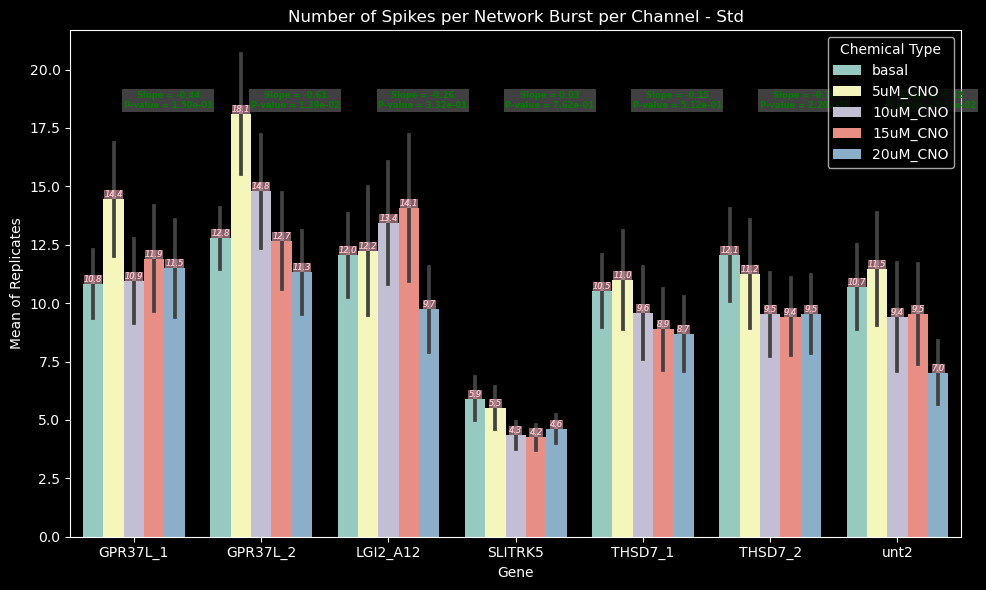

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.21131349618053452, 'r': 0.44844746396386237, 'p': 0.027957157802333803, 'se': 0.08979437655355507}, 'GPR37L_2': {'slope': 0.11099271914523856, 'r': 0.1253206098801511, 'p': 0.5595724855552298, 'se': 0.18733685890014268}, 'LGI2_A12': {'slope': 0.02397155260869563, 'r': 0.0661690791496879, 'p': 0.7586966167974423, 'se': 0.07706849871634569}, 'SLITRK5': {'slope': 0.21490571940987566, 'r': 0.10775996030121031, 'p': 0.616233571386873, 'se': 0.4227103647184436}, 'THSD7_1': {'slope': 0.13706097652173915, 'r': 0.4288807341877427, 'p': 0.03651023212805753, 'se': 0.06154989824265922}, 'THSD7_2': {'slope': 0.39912015913043475, 'r': 0.3314609709017698, 'p': 0.11359440991925512, 'se': 0.2422074676045739}, 'unt2': {'slope': 0.03181475956521745, 'r': 0.1294915395494721, 'p': 0.5464694518448985, 'se': 0.05194023378039375}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.268

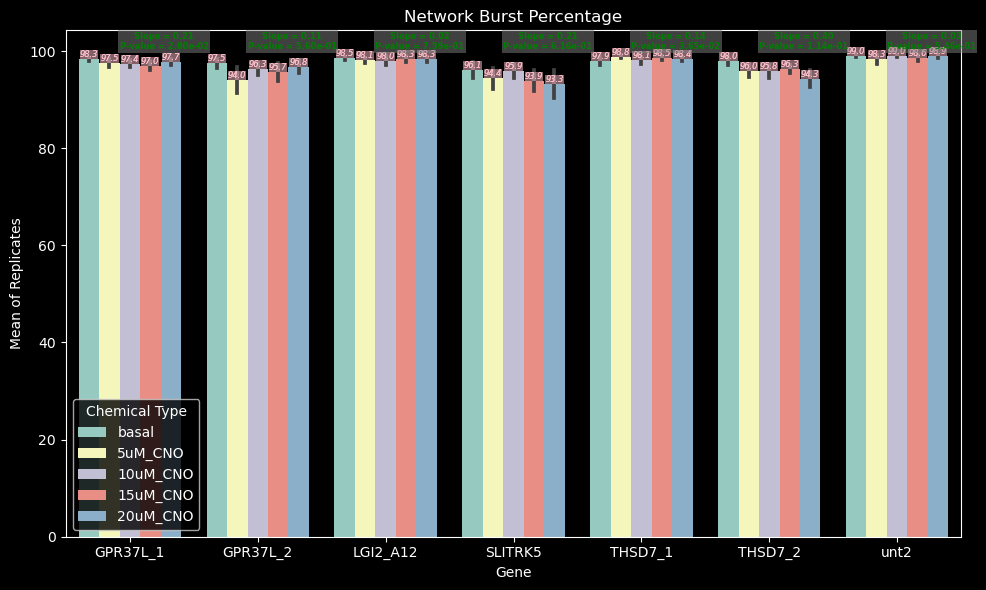

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.019135985609897398, 'r': -0.33109653738286715, 'p': 0.1140160846127092, 'se': 0.011627098597894554}, 'GPR37L_2': {'slope': -0.0072023810664016115, 'r': -0.09283774801691723, 'p': 0.6661305187316919, 'se': 0.016468744315116027}, 'LGI2_A12': {'slope': -0.011961542383431306, 'r': -0.16044431995241434, 'p': 0.4539021577381762, 'se': 0.015688752142310174}, 'SLITRK5': {'slope': -0.011724081094219258, 'r': -0.22329209407537745, 'p': 0.2942597373662981, 'se': 0.010911590878120865}, 'THSD7_1': {'slope': -0.02698244599573044, 'r': -0.515580766531995, 'p': 0.00991898593250532, 'se': 0.00956034357266019}, 'THSD7_2': {'slope': -0.01620994044930473, 'r': -0.2939818632147206, 'p': 0.16320742815858946, 'se': 0.01123625442197603}, 'unt2': {'slope': -0.007608226181430612, 'r': -0.12994746643072502, 'p': 0.5450457735883265, 'se': 0.012376735859941704}}
[0.26857143 1.26857143 2.26857143

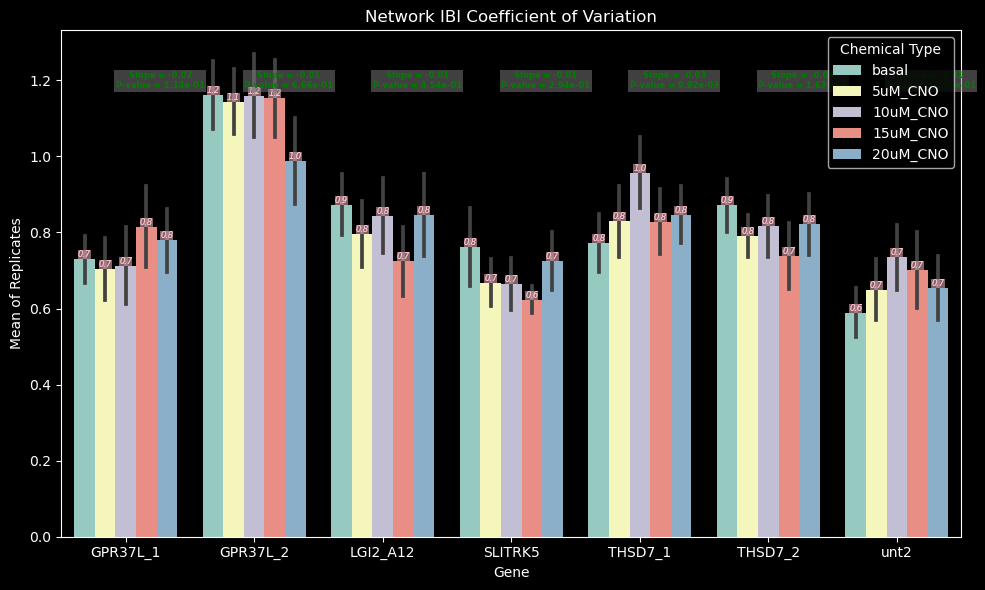

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.024747899764275386, 'r': -0.0791388456841369, 'p': 0.7131863525093214, 'se': 0.06646194338083944}, 'GPR37L_2': {'slope': -0.07378065929735424, 'r': -0.39742485263032157, 'p': 0.05446695292710471, 'se': 0.03632001411616954}, 'LGI2_A12': {'slope': 0.004945405938644419, 'r': 0.06334911679803362, 'p': 0.7687013863406629, 'se': 0.016610276121907706}, 'SLITRK5': {'slope': 0.0035525479087661804, 'r': 0.0820409261815741, 'p': 0.7031256934194341, 'se': 0.009200926293954378}, 'THSD7_1': {'slope': 0.01558002059242507, 'r': 0.1589341884661942, 'p': 0.45821782297867397, 'se': 0.020634014692308605}, 'THSD7_2': {'slope': -0.014412474637982104, 'r': -0.07069423038682963, 'p': 0.7427209531345111, 'se': 0.0433566074845954}, 'unt2': {'slope': -0.008104102771344239, 'r': -0.07139073854972004, 'p': 0.7402709339204578, 'se': 0.02414027281879926}}
[0.26857143 1.26857143 2.26857143 3.268571

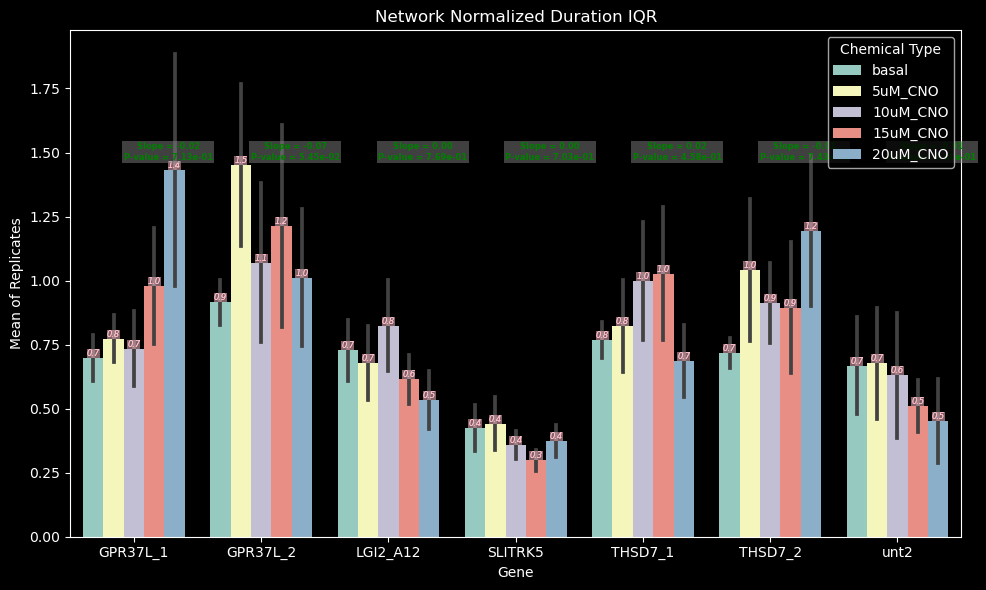

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.009962760869565218, 'r': -0.393398380442587, 'p': 0.05718827664139291, 'se': 0.004963925235248405}, 'GPR37L_2': {'slope': -0.0019052982608695655, 'r': -0.06764790284251596, 'p': 0.7534648582690495, 'se': 0.005991027247052222}, 'LGI2_A12': {'slope': -0.0069344682608695665, 'r': -0.5025545289802469, 'p': 0.012322127378995226, 'se': 0.0025433521404298783}, 'SLITRK5': {'slope': 0.00047125521739130484, 'r': 0.014833466689549336, 'p': 0.945154356407411, 'se': 0.006772583774239561}, 'THSD7_1': {'slope': -0.002478705217391305, 'r': -0.18514385912519887, 'p': 0.3864246169440443, 'se': 0.0028049830115484085}, 'THSD7_2': {'slope': 0.003920179130434782, 'r': 0.22045662150305753, 'p': 0.30059268585235843, 'se': 0.0036978793874393357}, 'unt2': {'slope': -0.0018181291304347812, 'r': -0.1337766222865309, 'p': 0.5331569274890393, 'se': 0.002871520080397452}}
[0.26857143 1.26857143 2.

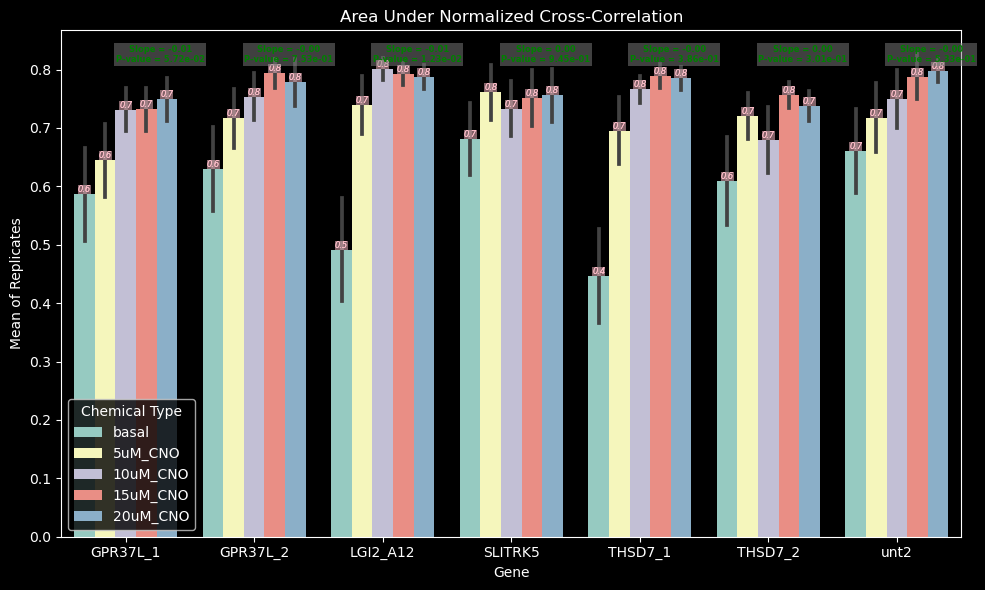

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.01106393260869557, 'r': -0.006081084009904839, 'p': 0.9775019227106949, 'se': 0.38789050426038757}, 'GPR37L_2': {'slope': 0.3036824469565217, 'r': 0.12192318510420083, 'p': 0.5703490875516583, 'se': 0.5270719043014523}, 'LGI2_A12': {'slope': -0.6517712169565217, 'r': -0.28777177656180275, 'p': 0.17270014562925562, 'se': 0.46244988977861173}, 'SLITRK5': {'slope': -0.2544725552173913, 'r': -0.1280538634298098, 'p': 0.5509699251348581, 'se': 0.4201909282694444}, 'THSD7_1': {'slope': -0.12234111043478268, 'r': -0.06897977215068127, 'p': 0.7487619777681982, 'se': 0.37722774216541827}, 'THSD7_2': {'slope': 0.2685030947826088, 'r': 0.11455254477829606, 'p': 0.5940390674610008, 'se': 0.4964378485984451}, 'unt2': {'slope': -0.3771149152173913, 'r': -0.15208831452091157, 'p': 0.47804759248109596, 'se': 0.5224981031895617}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.2685714

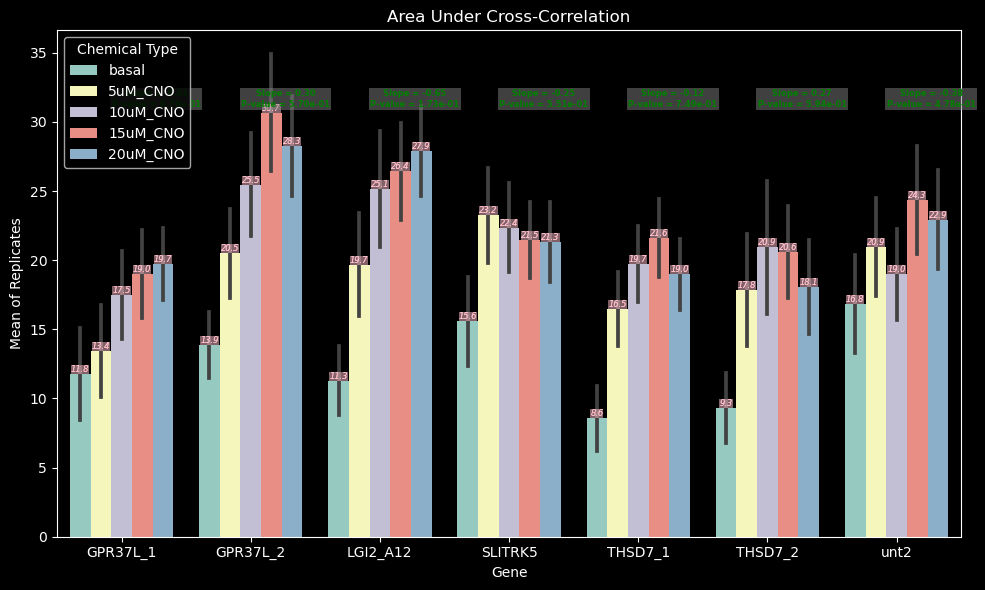

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.07701250995311609, 'r': 0.17374618156958918, 'p': 0.4168242735950817, 'se': 0.09306331204579435}, 'GPR37L_2': {'slope': 0.18237446710842473, 'r': 0.3004078931300032, 'p': 0.1537760686550738, 'se': 0.1234535562663418}, 'LGI2_A12': {'slope': -0.06391304347826085, 'r': -0.09842064473061085, 'p': 0.6472866819430256, 'se': 0.13777749212936688}, 'SLITRK5': {'slope': 0.4167688660551549, 'r': 0.5417779538541921, 'p': 0.006247357661760356, 'se': 0.13785150283816813}, 'THSD7_1': {'slope': -0.016521739130434785, 'r': -0.039052318907334224, 'p': 0.8562325879292906, 'se': 0.09012933620446954}, 'THSD7_2': {'slope': 0.31652173913043474, 'r': 0.3550740761262479, 'p': 0.08863685482504007, 'se': 0.17766818790006803}, 'unt2': {'slope': 0.06260869565217392, 'r': 0.1088444391031082, 'p': 0.6126674381410273, 'se': 0.12190713985469073}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.2685714

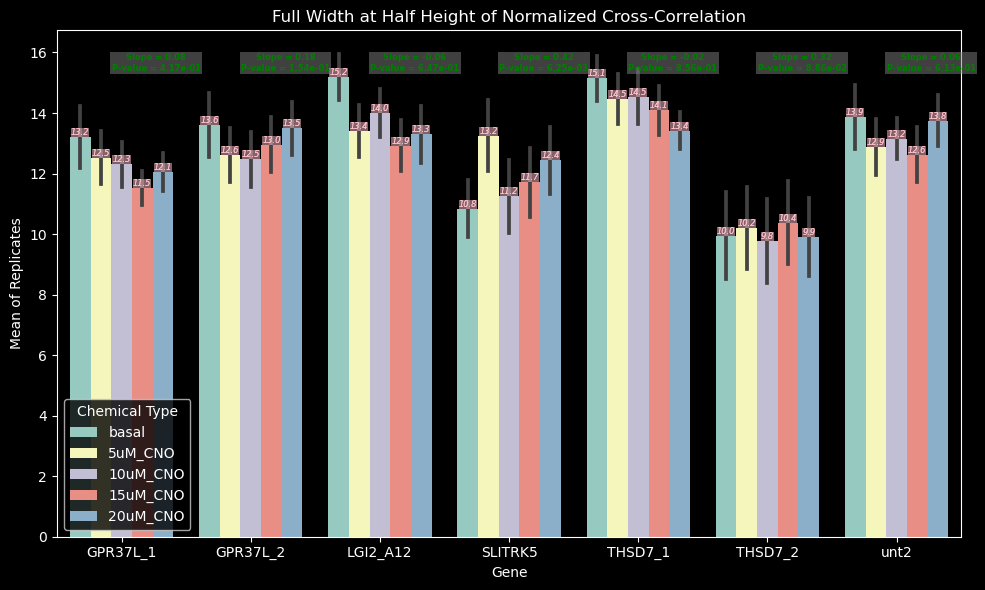

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 1.4199266160554607, 'r': 0.277878744447904, 'p': 0.18860369186142503, 'se': 1.046523823215184}, 'GPR37L_2': {'slope': 2.0747143206808385, 'r': 0.34607109102601885, 'p': 0.09761405377182314, 'se': 1.1991704258036726}, 'LGI2_A12': {'slope': 1.2569565217391303, 'r': 0.22622307661161992, 'p': 0.2878015943352425, 'se': 1.1538906121075165}, 'SLITRK5': {'slope': 1.9976144012533024, 'r': 0.4119431233546576, 'p': 0.04547973991651505, 'se': 0.9420660002663356}, 'THSD7_1': {'slope': 0.08478260869565209, 'r': 0.020370448074169642, 'p': 0.9247306677831381, 'se': 0.8871656700114461}, 'THSD7_2': {'slope': 2.0143478260869565, 'r': 0.4051759433891868, 'p': 0.049511920207718024, 'se': 0.9690341603818409}, 'unt2': {'slope': 1.5169565217391305, 'r': 0.3200089638626584, 'p': 0.12739931309793118, 'se': 0.9575019860416784}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6

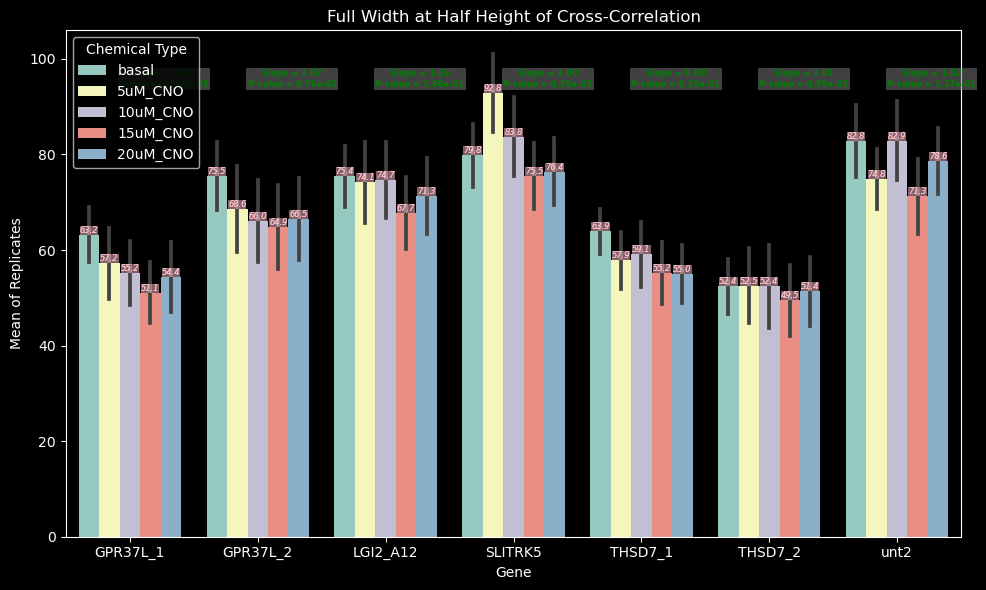

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.7626410756540697, 'r': 0.23535434200665098, 'p': 0.26825636187868007, 'se': 0.6714482149683091}, 'GPR37L_2': {'slope': -0.028381726619415945, 'r': -0.014447170856240227, 'p': 0.9465806434624877, 'se': 0.41879292415375874}, 'LGI2_A12': {'slope': -0.4633173178260869, 'r': -0.1916347743614167, 'p': 0.3696912447050483, 'se': 0.5059041813905518}, 'SLITRK5': {'slope': 0.8553423732434576, 'r': 0.28200781151796267, 'p': 0.18184834347740816, 'se': 0.620401306833566}, 'THSD7_1': {'slope': -0.405057862173913, 'r': -0.23168037350935028, 'p': 0.27601578531268106, 'se': 0.36260722676771096}, 'THSD7_2': {'slope': 0.12595770173913037, 'r': 0.03943822763005417, 'p': 0.8548265133644698, 'se': 0.6803901065299418}, 'unt2': {'slope': -0.30521049173913056, 'r': -0.09528546015985273, 'p': 0.6578438329366041, 'se': 0.6797996376877488}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 

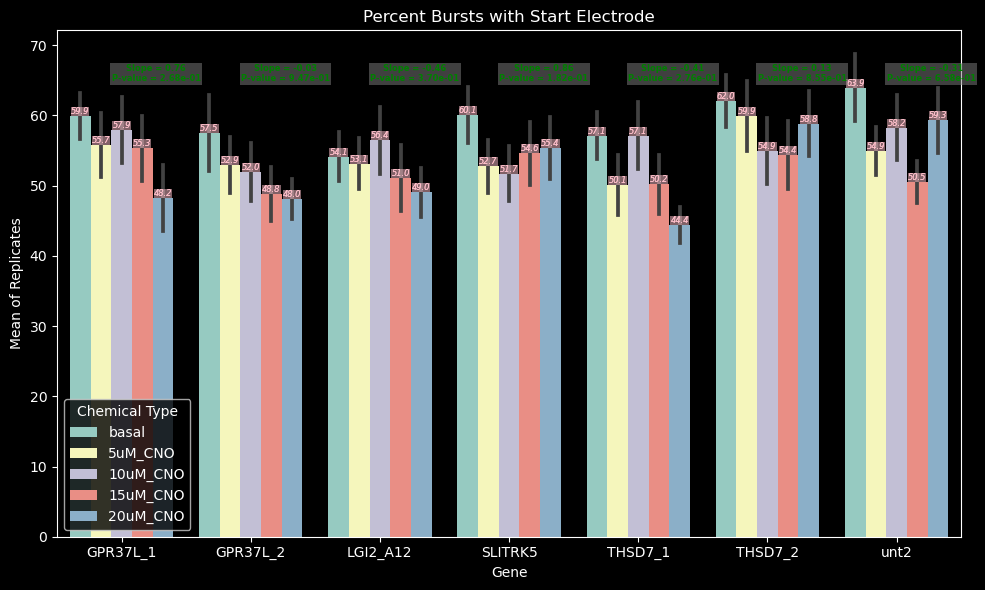

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 51.224565733546655, 'r': 0.5612846159307299, 'p': 0.004321229284884842, 'se': 16.103351695683614}, 'GPR37L_2': {'slope': 2.748144108233487, 'r': 0.028284741139715904, 'p': 0.8956210457375644, 'se': 20.706283732007908}, 'LGI2_A12': {'slope': 8.416248790869567, 'r': 0.07014768495123914, 'p': 0.7446451671737343, 'se': 25.516595459516004}, 'SLITRK5': {'slope': 18.313110201724093, 'r': 0.17240968118819042, 'p': 0.42047266307022735, 'se': 22.306761220167875}, 'THSD7_1': {'slope': 16.968970640869568, 'r': 0.15142553458129696, 'p': 0.4799902611856526, 'se': 23.616087546038194}, 'THSD7_2': {'slope': 36.646914892608706, 'r': 0.22918257600712133, 'p': 0.2813715621465128, 'se': 33.18397762382076}, 'unt2': {'slope': 24.03588682086956, 'r': 0.20989989472575404, 'p': 0.32490644123508317, 'se': 23.869997223168227}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.2

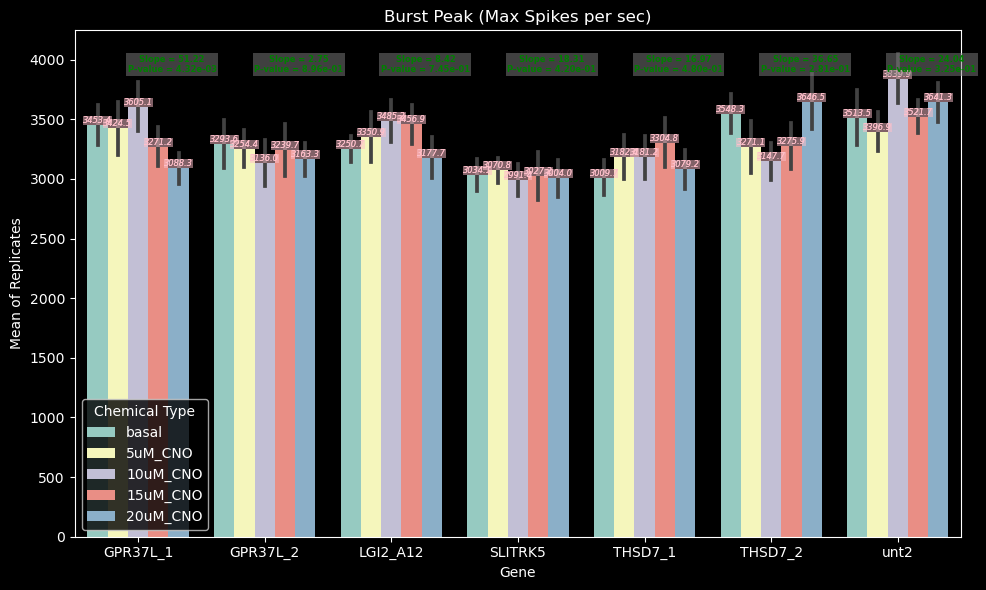

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.4956555837279766, 'r': -0.1991013851475398, 'p': 0.35097043747771695, 'se': 0.5201290432065647}, 'GPR37L_2': {'slope': 0.19692395741163282, 'r': 0.07963196178296718, 'p': 0.7114735353402977, 'se': 0.5255553122021559}, 'LGI2_A12': {'slope': -0.08695652173913043, 'r': -0.03488712325103658, 'p': 0.8714348208544956, 'se': 0.5310815405197897}, 'SLITRK5': {'slope': -0.29024251905477927, 'r': -0.14151845472987612, 'p': 0.5094992196314727, 'se': 0.4328561245843395}, 'THSD7_1': {'slope': -0.052173913043478265, 'r': -0.0316789980471516, 'p': 0.8831743849366147, 'se': 0.35095594458782237}, 'THSD7_2': {'slope': -0.7343478260869566, 'r': -0.1860400607089936, 'p': 0.3840890274570695, 'se': 0.8268661154584793}, 'unt2': {'slope': 0.40652173913043477, 'r': 0.1337612745444678, 'p': 0.5332043348178482, 'se': 0.642128052326465}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.

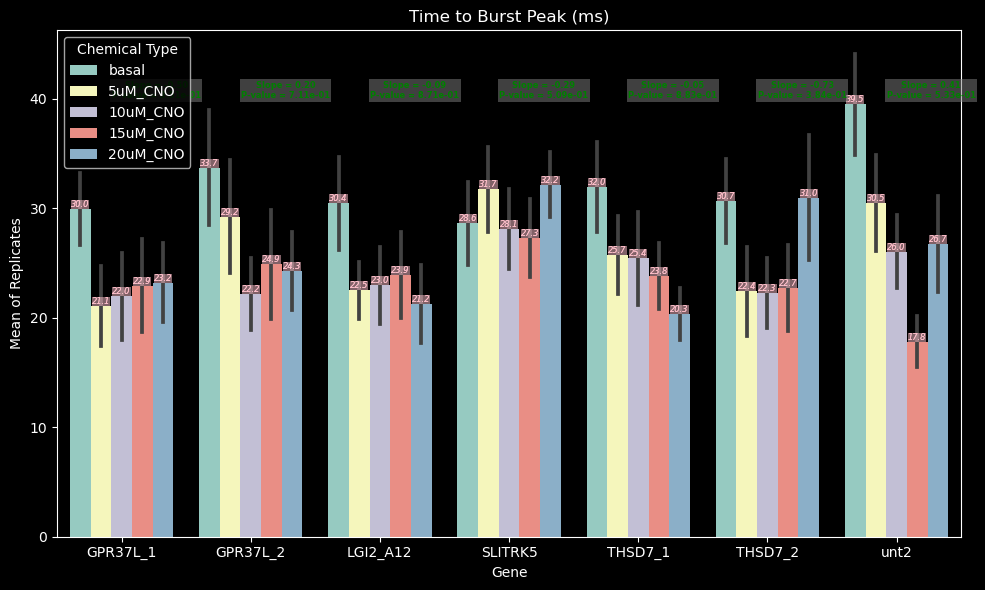

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'GPR37L_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'LGI2_A12': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'SLITRK5': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'unt2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


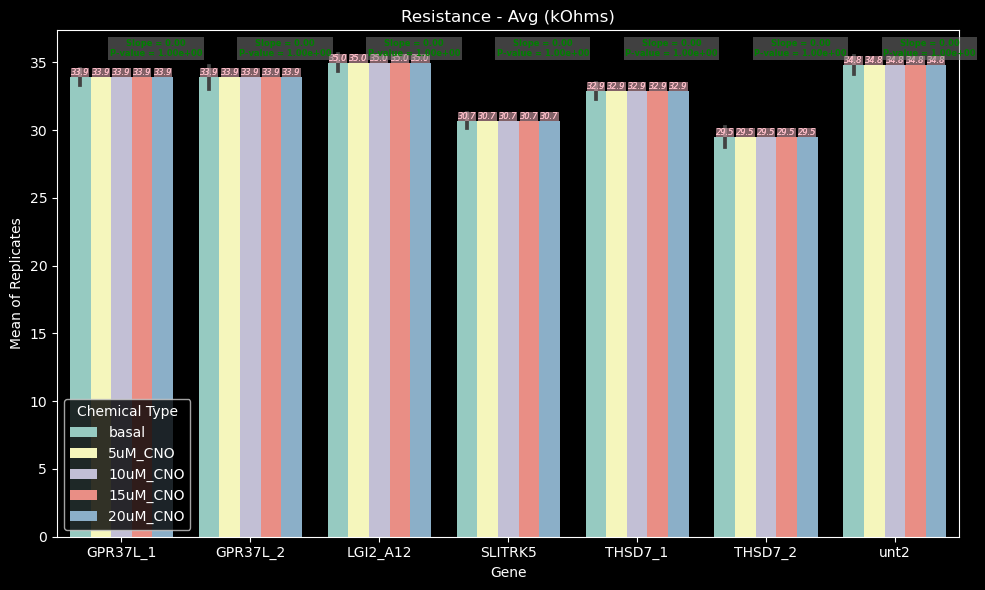

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'GPR37L_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'LGI2_A12': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'SLITRK5': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'unt2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


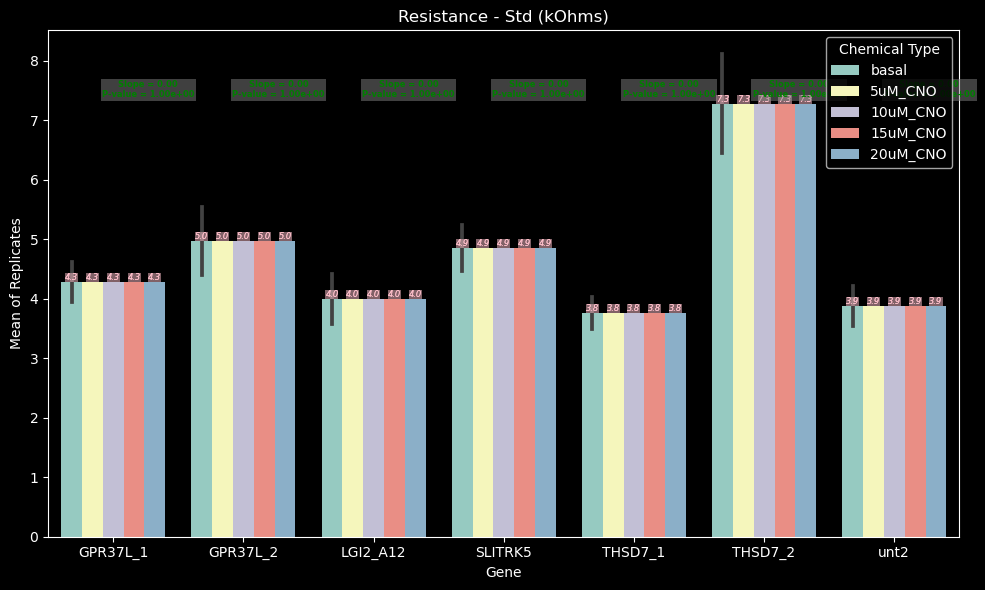

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'GPR37L_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'LGI2_A12': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'SLITRK5': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'unt2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


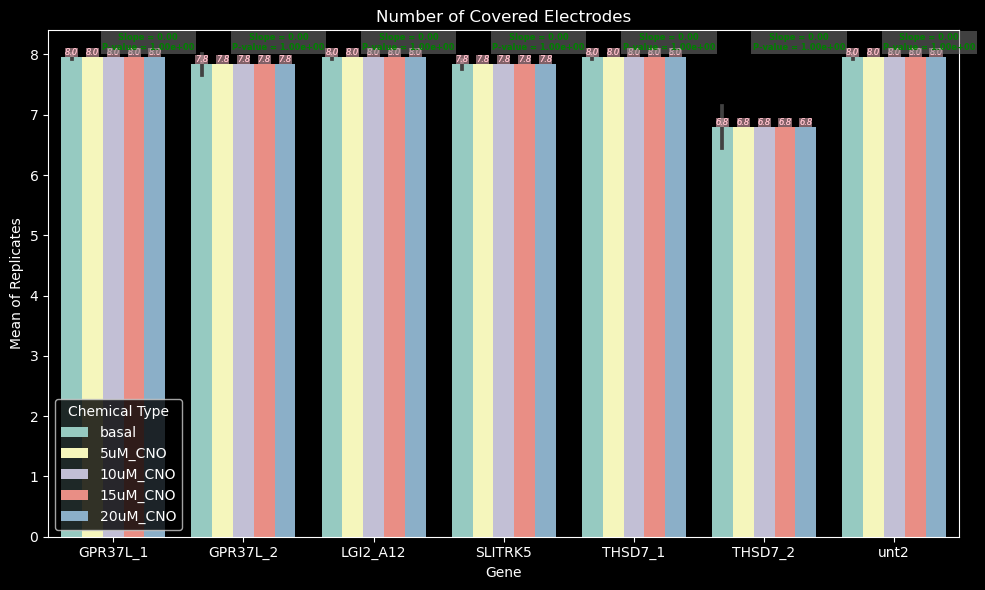

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'GPR37L_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'LGI2_A12': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'SLITRK5': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_1': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'THSD7_2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}, 'unt2': {'slope': 0.0, 'r': 0.0, 'p': 1.0, 'se': 0.0}}
[0.26857143 1.26857143 2.26857143 3.26857143 4.26857143 5.26857143
 6.26857143]


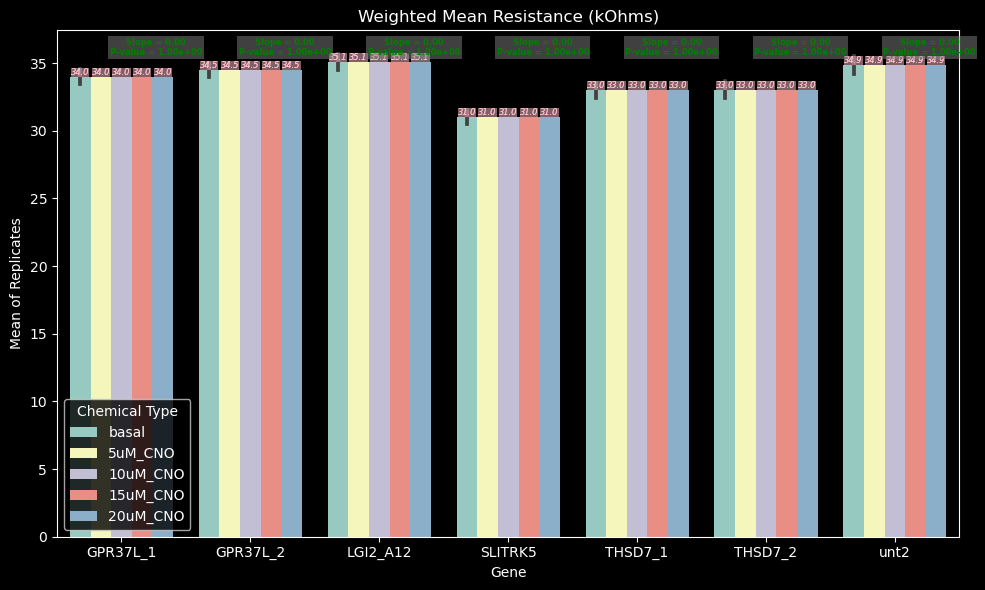

In [39]:
def create_bar_chart(testparameter, df, show_barlabels = True, control_var="unt2"):
    bar_width=0.20
    plt.figure(figsize=(10, 6)) # Adjust the size as needed
    # Create a bar plot
    ax = sns.barplot(x='Gene', y='Value', hue='Chemical_Type', data=df, errorbar='se')

    plt.title(f"{testparameter}")
    plt.xlabel('Gene')
    plt.ylabel('Mean of Replicates')
    plt.legend(title='Chemical Type')
    if show_barlabels:
        add_barlabels(ax)
    gene_slope_dict = compute_slope(df)
    print(f"GENE_SLOPE_dICT: {gene_slope_dict}")
    if show_barlabels:
        add_barlabels(ax)  # This function needs to be defined elsewhere
    add_slope_labels(ax, df, gene_slope_dict, bar_width)  # Adding slope labels to the plot
    plt.tight_layout()
    save_figfile = f"{parent}/comparison_plots/{PERTURBATION}/{plate_type}/{EXPERIMENT_TIME}/{testparameter}"
    ensure_dirs_exists(save_figfile)
    plt.savefig(save_figfile)
    plt.show()
    return
#### test param imputed! ONLY FOR PLOTS
for test_param, table in TestParams_dict_imputed.items():
    if table['Chemical_Type'].nunique() > 1:
        create_bar_chart(test_param, table)